## To do
 - Create Novel Variables for % change PSA and DRE (Done)
 - Add remaining models as included in the Proposal (Done)

# Imports

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from statistics import mean, stdev
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline

In [2]:
path_1 = '/Users/carolchu/Desktop/msba/Semester_2/Machine_Learning/midterm project/prostate_comprehensive.csv' #comprehensive dataset
raw = pd.read_csv(path_1)
print(f"Rows: {raw.shape[0]} | Cols: {raw.shape[1]}")

Rows: 76678 | Cols: 214


In [3]:
# Display total and percentage of null values per column
def nulls_info(df, n=15):
    
    nulls_tab = pd.concat([
        df.isnull().sum().rename('Total'),
        df.isnull().mean().rename('Percent').mul(100),
        df.dtypes.rename('DataType')
    ], axis=1).sort_values(by='Total', ascending=False).round(1)
    
    return nulls_tab.head(n)

# Preliminary EDA

In [4]:
selected_cols = ['age', 'agelevel', 'race7', 'height_f',
       'weight_f', 'bmi_curr', 'educat', 'cig_stat', 'psa_level0', 
        'psa_level1', 'dre_result0', 'dre_result1', 'pros_cancer']

raw1 = raw[selected_cols]

nulls_info(raw1)

,Total,Percent,DataType
psa_level1,44018,57.4,float64
psa_level0,42454,55.4,float64
dre_result0,38338,50.0,float64
dre_result1,38338,50.0,float64
bmi_curr,4042,5.3,float64
height_f,3555,4.6,float64
weight_f,3547,4.6,float64
educat,3036,4.0,float64
cig_stat,2848,3.7,float64
age,0,0.0,int64


In [5]:
raw['pros_gleason'].isnull().sum()

68024

In [6]:
var =["psa_result0", "psa_result1","psa_result2","psa_result3","psa_result4", "psa_result5",
    "psa_level0", "psa_level1","psa_level2","psa_level3","psa_level4", "psa_level4", "psa_level5",
    "dre_result0","dre_result1","dre_result2","dre_result3"]

nulls_info(raw[var])

,Total,Percent,DataType
psa_level4,54520,71.1,float64
psa_level4,54520,71.1,float64
psa_level5,50743,66.2,float64
psa_level3,46189,60.2,float64
psa_level2,45023,58.7,float64
psa_level1,44018,57.4,float64
psa_level0,42454,55.4,float64
dre_result2,38338,50.0,float64
dre_result1,38338,50.0,float64
dre_result0,38338,50.0,float64


# Preliminary Cleaning

In [7]:
#only keep columns with at least 40% non-NaN values
raw_reduced = raw.dropna(axis=1, thresh=len(raw) * 0.4) 
print(f"Rows: {raw_reduced.shape[0]} | Cols: {raw_reduced.shape[1]}")

Rows: 76678 | Cols: 156


## Select Initial Variables

In [8]:
columns_of_interest = [
    
    #Identifiers (Remove All before modeling)
    "plco_id", # Participant ID (can drop)
    "ph_pros_trial", # Has the participant had Prostate Cancer?
    "pros_eligible_bq", # Is the Participant eligible for the study?
    "ph_any_trial", # Has the participant had any kind of Cancer?
    "ph_pros_bq", "ph_any_bq", #Similar to ph_pros_trial and pros_eligible_bq (IGNORE)
    
    #Medical History
    "age", #age
    "agelevel",
    "race7", #race
    "height_f", #height (in) at baseline
    "weight_f", #Weight (lbs) at baseline
    "bmi_curr",#BMI at baseline
    
    #Socio Economic
    "educat", #Education
    "cig_stat", #Smoking Status
    
    #Prostate Cancer Related
    "psa_result0", "psa_result1", 
    #"psa_result2","psa_result3","psa_result4", "psa_result5",
    "psa_level0", "psa_level1",
    #"psa_level2","psa_level3","psa_level4", "psa_level4", "psa_level5",
    "dre_result0","dre_result1",
    #"dre_result2","dre_result3",
    "pros_cancer" # Cancer Yes or No (Target Variable)
    
    
    #Other
    #"biopplink0", "biopplink1", "biopplink2", "biopplink3", "biopplink4", "biopplink5",  
    #"pros_mra_stat0", "pros_mra_stat1","pros_mra_stat2","pros_mra_stat3","pros_mra_stat4","pros_mra_stat5",
    #"pros_cancer_first",
    #"pros_stage", 
    #"pros_gleason"
    #"pros_dx_psa"
    #, "pros_behavior", "pros_pathstage"
]

df = raw_reduced[columns_of_interest]
df.head()
print(f"Rows: {df.shape[0]} | Cols: {df.shape[1]}")

Rows: 76678 | Cols: 21


In [9]:
df.columns

Index(['plco_id', 'ph_pros_trial', 'pros_eligible_bq', 'ph_any_trial',
       'ph_pros_bq', 'ph_any_bq', 'age', 'agelevel', 'race7', 'height_f',
       'weight_f', 'bmi_curr', 'educat', 'cig_stat', 'psa_result0',
       'psa_result1', 'psa_level0', 'psa_level1', 'dre_result0', 'dre_result1',
       'pros_cancer'],
      dtype='object')

## Keep Eligible Participants
- Keep only History of Prostate Cancer = No
- Keep Eligible = Yes

In [10]:
df = df[df["pros_eligible_bq"] == 1] # Keep only participants eligible for the study
df = df[df["ph_pros_trial"] == 0] # Keep only participants with no history of prostate cancer
print(df['ph_pros_trial'].value_counts()) # Needs to print only 0

0    73530
Name: ph_pros_trial, dtype: int64


# EDA

- **73530 Observations**: After Keeping only participants eligible to be in the study

# Univariative Analysis

## Prostate Cancer Confirmed Cases
- 12% Confirmed Cases of Prostate Cancer 
- 88% Negative Cases of Prostate Cancer

In [11]:
df_c = df[df["pros_cancer"] == 1]

data = df["pros_cancer"].value_counts()
percentages = (data / data.sum()) * 100
result = pd.concat([data, percentages], axis=1).round(2)
label_map = {0: "Negative", 1: "Positive"}
result.index = result.index.map(label_map)
result.columns = ['Count', 'Percentage']
print(result)

          Count  Percentage
Negative  65015       88.42
Positive   8515       11.58


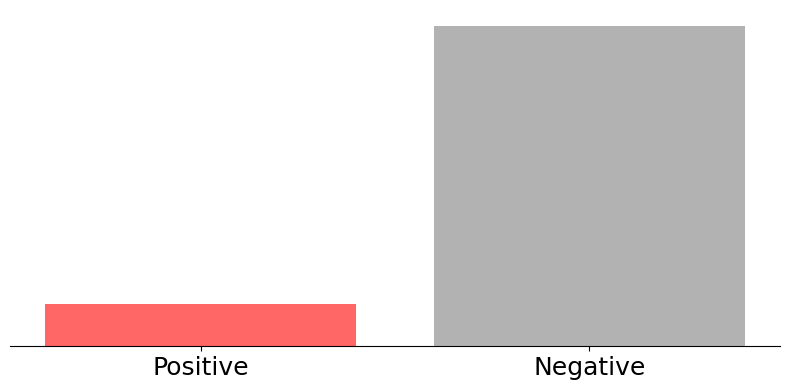

In [13]:
# Calculate counts and percentages
data = df["pros_cancer"].value_counts()
percentages = (data / data.sum()) * 100
result = pd.concat([data, percentages], axis=1).round(2)
label_map = {0: "Negative", 1: "Positive"}
result.index = result.index.map(label_map)
result.columns = ['Count', 'Percentage']

# Plotting
plt.figure(figsize=(8, 4))  # Define figure size
colors = ['red', 'grey']  # Color red for 'Positive', grey for 'Negative'
result_sorted = result.sort_values(by='Count', ascending=True)  # Sort data for better visual hierarchy

# Create the bar plot vertically
bars = plt.bar(result_sorted.index, result_sorted['Count'], color=colors, alpha=0.6)

# Add text annotations inside the bars
for bar, (index, row) in zip(bars, result_sorted.iterrows()):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{row['Percentage']}%", color='white', va='bottom', ha='center', fontweight='bold', fontsize=10)

# Formatting details
plt.title('', fontsize=20)  # Set the plot title
plt.gca().spines['top'].set_visible(False)  # Hide the top spine
plt.gca().spines['right'].set_visible(False)  # Hide the right spine
plt.gca().spines['left'].set_visible(False)  # Optionally, hide the left spine

# Remove y-axis labels
plt.gca().yaxis.set_major_locator(plt.NullLocator())  # No y-ticks
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())  # No y-tick labels

# Set x-tick label size
plt.gca().xaxis.set_tick_params(labelsize=18)  # Bigger font size for x-ticks

plt.tight_layout()  # Adjust layout to fit the figure area
plt.show()

## History of Cancer

In [14]:
data = df['ph_any_trial'].value_counts()
percentages = (data / data.sum()) * 100
result = pd.concat([data, percentages], axis=1).round(2)
label_map = {0: "No History of Cancer", 1: "History of Cancer", 9: "Unknown"}
result.index = result.index.map(label_map)
result.columns = ['Count', 'Percentage']
print(result)

                      Count  Percentage
No History of Cancer  71872       97.75
History of Cancer      1637        2.23
Unknown                  21        0.03


### History of Cancer with Previous Cancer 
 - No difference (Breakdown is similar)

In [15]:
data = df[df['ph_any_trial'] == 1]
data2 = data['pros_cancer'].value_counts()
percentages = (data2 / data2.sum()) * 100
result = pd.concat([data2, percentages], axis=1).round(2)
label_map = {0: "Negative", 1: "Positive"}
result.index = result.index.map(label_map)
result.columns = ['Count', 'Percentage']
print(result)

          Count  Percentage
Negative   1455       88.88
Positive    182       11.12


## Age

Age for all participants: Mean = 62.7 | Median = 62.0
Age for Confirmed Cases: Mean = 63.5 | Median = 63.0


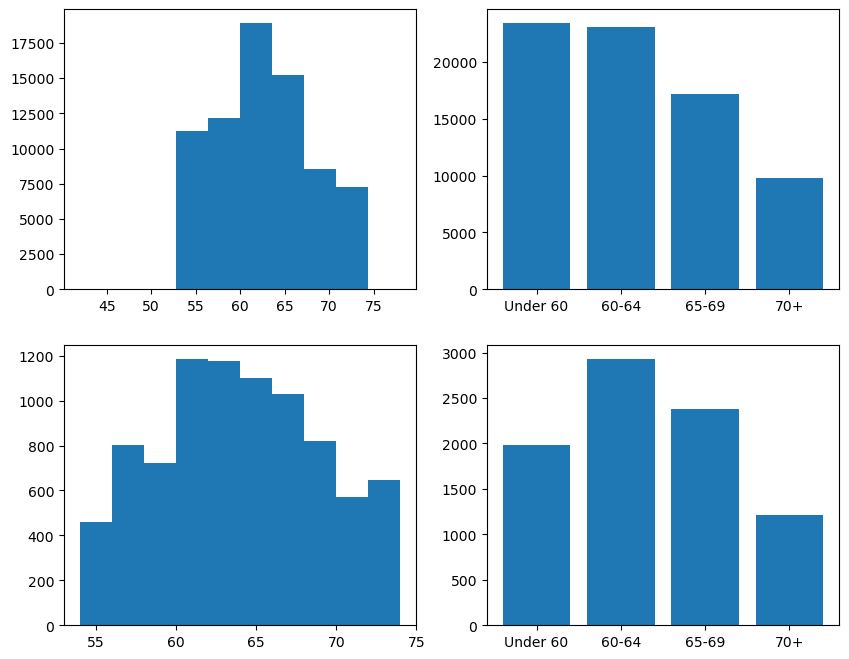

In [16]:
# All Participants
age = df['age']
age_2 = df_c['age'] # Confirmed Cases

agelevel = df['agelevel'].value_counts()
agelevel_2 = df_c['agelevel'].value_counts()

agelevel_map = {
    0: "Under 60",
    1: "60-64",
    2: "65-69",
    3: "70+"
}
ordered_agelevel = ["Under 60", "60-64", "65-69", "70+"]
ordered_agelevel_2 = ["Under 60", "60-64", "65-69", "70+"]

agelevel.index = agelevel.index.map(agelevel_map)
agelevel_2.index = agelevel_2.index.map(agelevel_map)

agelevel = agelevel.reindex(ordered_agelevel) 
agelevel_2 = agelevel_2.reindex(ordered_agelevel_2)  # Confirmed Cases


fig, ax = plt.subplots(ncols=2, nrows=2,figsize=(10,8))
ax[0][0].hist(age)
ax[0][1].bar(agelevel.index, height=agelevel.values)

ax[1][0].hist(age_2)
ax[1][1].bar(agelevel_2.index, height=agelevel_2.values)

print(f"Age for all participants: Mean = {df['age'].mean().round(1)} | Median = {df['age'].median()}")
print(f"Age for Confirmed Cases: Mean = {df_c['age'].mean().round(1)} | Median = {df_c['age'].median()}")
plt.show()

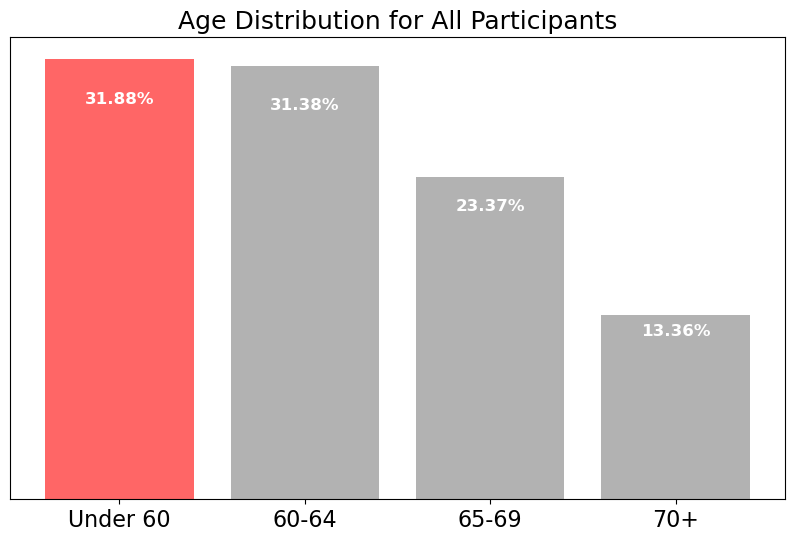

In [17]:
total = agelevel.sum()
percentages = (agelevel / total * 100).round(2)  # round to 2 decimal places

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Determine the highest bar
max_value = agelevel.max()
colors = ['red' if value == max_value else 'grey' for value in agelevel.values]  # Red for the max value, grey for others

bars = plt.bar(agelevel.index, height=agelevel.values, color=colors, alpha=0.6)

# Add text annotations inside the bars
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval / 1.1, f'{percentage}%', ha='center', va='center', color='white', fontsize=12, fontweight='bold')

# Add title
plt.title('Age Distribution for All Participants', fontsize=18)
plt.xticks(fontsize=16) 

# Hide spines and ticks on the y-axis
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

plt.gca().yaxis.set_major_locator(plt.NullLocator())  # No y ticks
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())  # No y labels

plt.show()

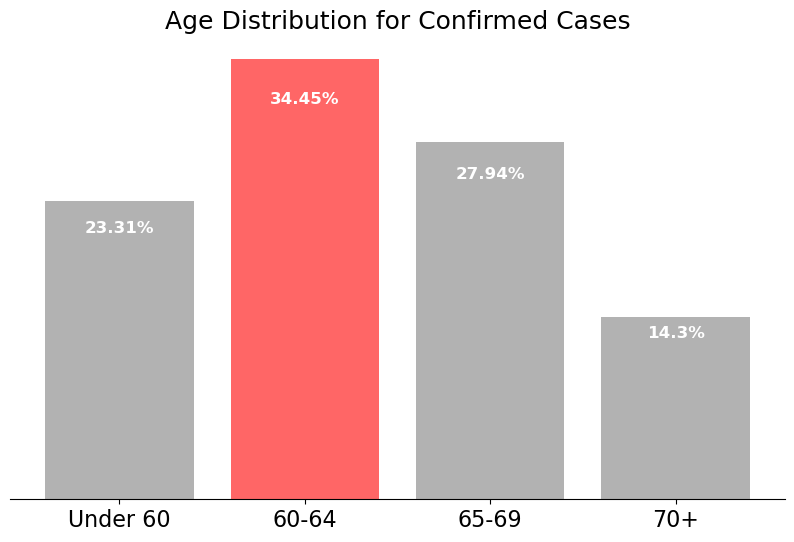

In [75]:
total = agelevel_2.sum()
percentages = (agelevel_2 / total * 100).round(2)  # round to 2 decimal places

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Determine the highest bar
max_value = agelevel_2.max()
colors = ['red' if value == max_value else 'grey' for value in agelevel_2.values]  # Red for the max value, grey for others

bars = plt.bar(agelevel_2.index, height=agelevel_2.values, color=colors, alpha=0.6)

# Add text annotations inside the bars
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval / 1.1, f'{percentage}%', ha='center', va='center', color='white', fontsize=12, fontweight='bold')

# Add title
plt.title('Age Distribution for Confirmed Cases', fontsize=18)
plt.xticks(fontsize=16) 

# Hide spines and ticks on the y-axis
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.gca().yaxis.set_major_locator(plt.NullLocator())  # No y ticks
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())  # No y labels

plt.show()

In [76]:
max_value

2933

In [28]:
df_un = df[df["pros_cancer"] == 0]
age_3 = df_un['age'] # Not Diagnosed Cases
agelevel_3 = df_c['agelevel'].value_counts()
ordered_agelevel_3 = ["Under 60", "60-64", "65-69", "70+"]
agelevel_3.index = agelevel_3.index.map(agelevel_map)
agelevel_3 = agelevel_3.reindex(ordered_agelevel_3)  # Not Diagnosed Cases
agelevel_3

Under 60    1985
60-64       2933
65-69       2379
70+         1218
Name: agelevel, dtype: int64

In [35]:
# For Not Diagnosed Cases
df_un = df[df["pros_cancer"] == 0]
age_3 = df_un['age']
bins = [0, 60, 64, 69, float('inf')]
labels = ["Under 60", "60-64", "65-69", "70+"]
age_groups = pd.cut(age_3, bins=bins, labels=labels)
agelevel_3 = age_groups.value_counts().reindex(labels).fillna(0)

agelevel_3.index = agelevel_3.index.map(agelevel_map)

In [73]:
max_value

78

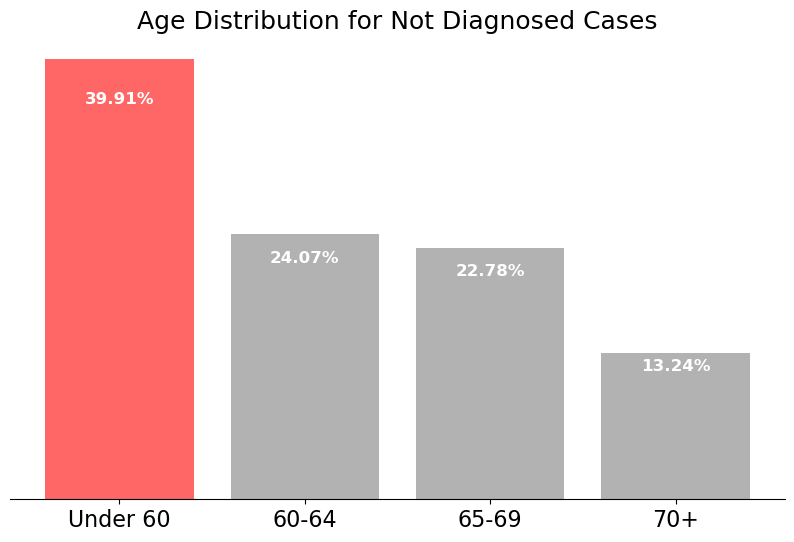

In [40]:
# Count occurrences of each age group
agelevel_3 = age_groups.value_counts().reindex(labels).fillna(0)

plt.figure(figsize=(10, 6))

max_value_3 = agelevel_3.max()
colors_3 = ['red' if value == max_value_3 else 'grey' for value in agelevel_3.values]

bars = plt.bar(agelevel_3.index, height=agelevel_3.values, color=colors_3, alpha=0.6)

# Add text annotations inside the bars with percentages
for bar, percentage in zip(bars, percentages_3):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval / 1.1, f'{percentage}%', ha='center', va='center', color='white', fontsize=12, fontweight='bold')

plt.title('Age Distribution for Not Diagnosed Cases', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks([])  # Hide y-axis ticks
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.show()

## Race

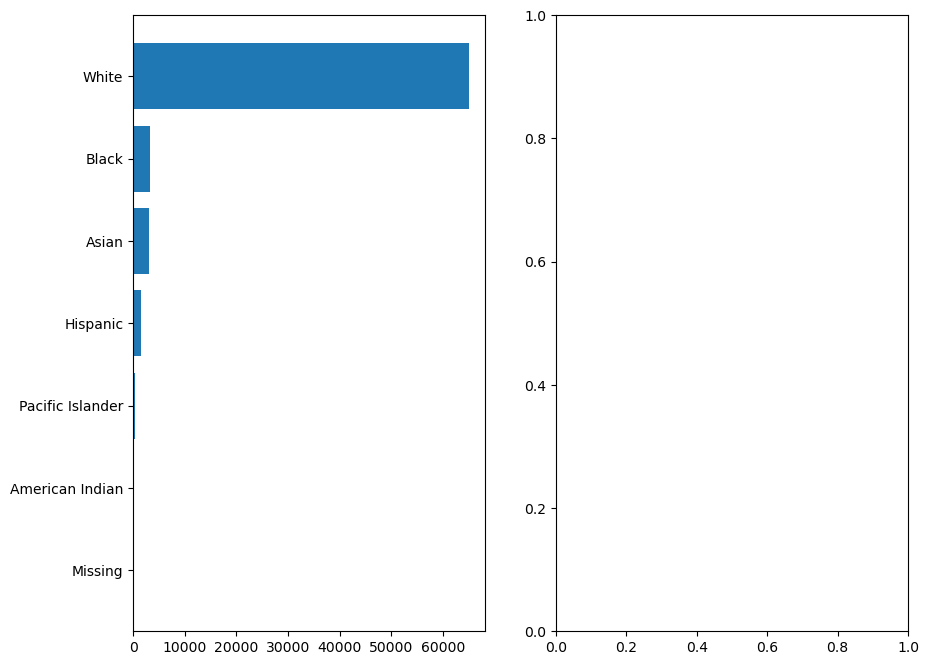

In [41]:
race = df['race7'].value_counts().sort_values()

#White and Black are non-hispanic
labels = {1:"White" ,2:"Black", 3:"Hispanic", 4:"Asian", 5:"Pacific Islander", 6:"American Indian", 7:"Missing"} 
race.index = race.index.map(labels)

fig, ax = plt.subplots(ncols=2, nrows=1,figsize=(10,8))

ax[0].barh(race.index, race.values)
plt.show()

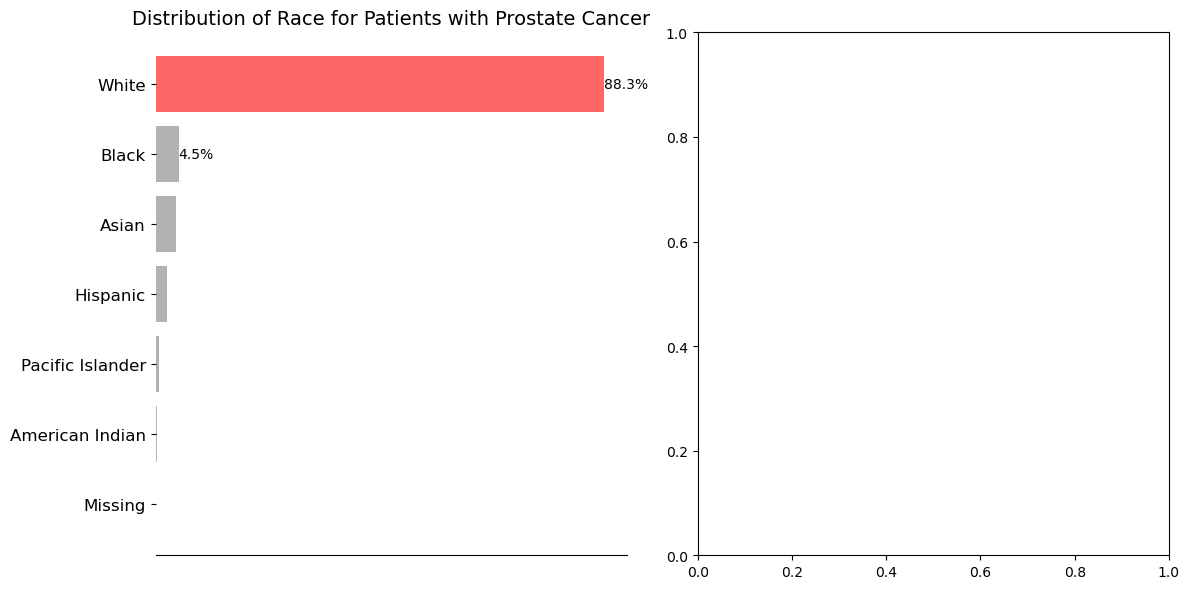

In [42]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'race7' is a column with categorical data about race

# Calculate counts and sort
race = df['race7'].value_counts().sort_values()

# Define labels (White and Black are non-hispanic)
labels = {
    1: "White",
    2: "Black",
    3: "Hispanic",
    4: "Asian",
    5: "Pacific Islander",
    6: "American Indian",
    7: "Missing"
}
race.index = race.index.map(labels)

# Create a subplot
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))  # Adjusted for better fit

# Define colors: red for "White", grey for others
colors = ['red' if x == "White" else 'grey' for x in race.index]

# Bar plot for race data
ax[0].barh(race.index, race.values, color=colors, alpha=0.6)

# Add text annotations inside the bars for only the first two bars
for i, (index, value) in enumerate(race.items()):
    if i > 4:  # Only for the first two bars
        percentage = f"{value / race.sum() * 100:.1f}%"
        ax[0].text(value + 1, i, percentage, color='black', va='center', fontsize=10)

# Formatting details
ax[0].set_title('Distribution of Race for Patients with Prostate Cancer', fontsize=14)  # Title for the first subplot
ax[0].spines['top'].set_visible(False)  # Hide the top spine
ax[0].spines['right'].set_visible(False)  # Hide the right spine
ax[0].spines['left'].set_visible(False)
ax[0].spines['left'].set_visible(False)# Optionally, hide the left spine

# Set x-tick label size
ax[0].xaxis.set_tick_params(labelsize=12)  # Bigger font size for x-ticks
ax[0].yaxis.set_tick_params(labelsize=12)  # Bigger font size for y-ticks (if you have y-ticks)
ax[0].xaxis.set_major_locator(plt.NullLocator())

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

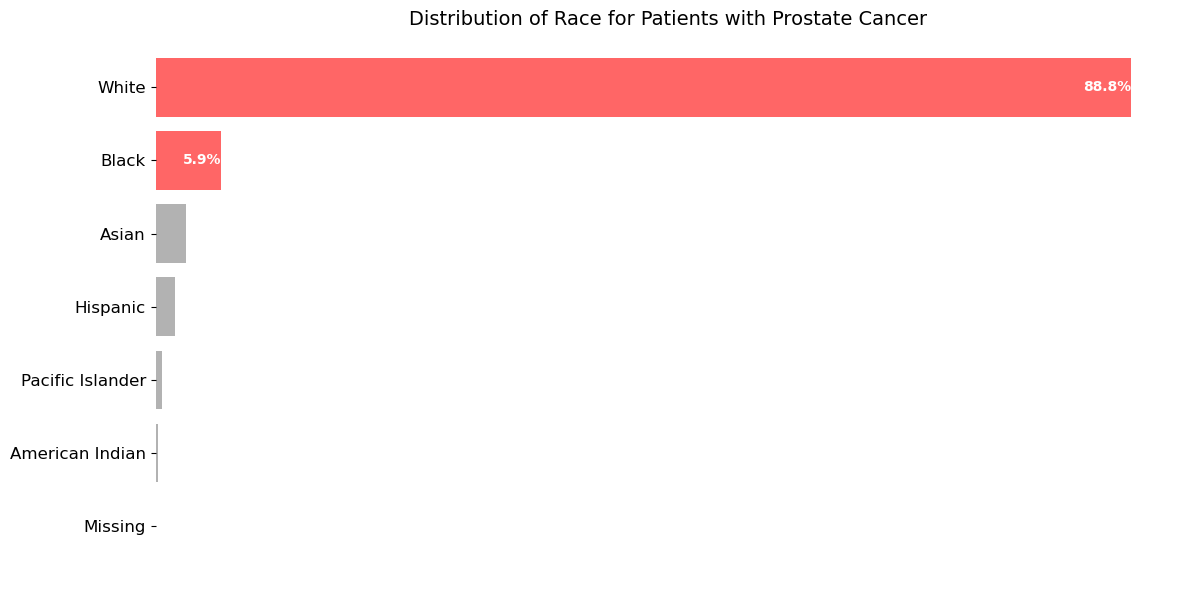

In [43]:
# Calculate counts and sort
race = df_c['race7'].value_counts().sort_values()

# Define labels (White and Black are non-Hispanic)
labels = {
    1: "White",
    2: "Black",
    3: "Hispanic",
    4: "Asian",
    5: "Pacific Islander",
    6: "American Indian",
    7: "Missing"
}
race.index = race.index.map(labels)

# Define colors: red for the highest counts, grey for others
top_two_indices = race.nlargest(2).index  # Get the indices of the top two counts
colors = ['red' if label in top_two_indices else 'grey' for label in race.index]

# Create the bar plot
plt.figure(figsize=(12, 6))  # Define figure size
plt.barh(race.index, race.values, color=colors, alpha=0.6)

# Add text annotations inside the bars only for the top two values
top_two_values = race.nlargest(2)  # Get the top two values
for i, (label, value) in enumerate(race.items()):
    if label in top_two_values.index:  # Check if the label is one of the top two
        percentage = f"{value / race.sum() * 100:.1f}%"  # Calculate percentage
        plt.text(value, i, percentage, color='white', va='center', fontweight='bold', fontsize=10, horizontalalignment='right')

# Formatting details
plt.title('Distribution of Race for Patients with Prostate Cancer', fontsize=14)  # Set the plot title
plt.gca().spines['top'].set_visible(False)  # Hide the top spine
plt.gca().spines['right'].set_visible(False)  # Hide the right spine
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)# Optionally, hide the left spine

# Remove x-axis labels
plt.gca().xaxis.set_major_locator(plt.NullLocator())  # No x-ticks
plt.gca().xaxis.set_major_formatter(plt.NullFormatter())  # No x-tick labels

# Set y-tick label size
plt.gca().yaxis.set_tick_params(labelsize=12)  # Bigger font size for y-ticks

plt.tight_layout()  # Adjust layout to fit the figure area
plt.show()

## Smoking History (Cigarettes)

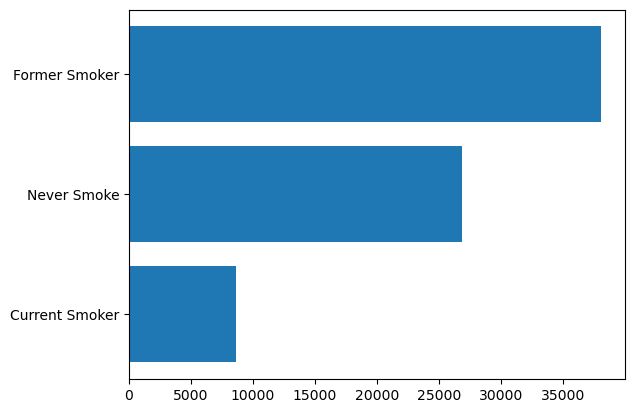

In [44]:
smoke = df['cig_stat'].value_counts().sort_values()
label = {0:"Never Smoke", 1:"Current Smoker", 2:"Former Smoker" }
smoke.index = smoke.index.map(label)

plt.barh(smoke.index, smoke.values)
plt.show()

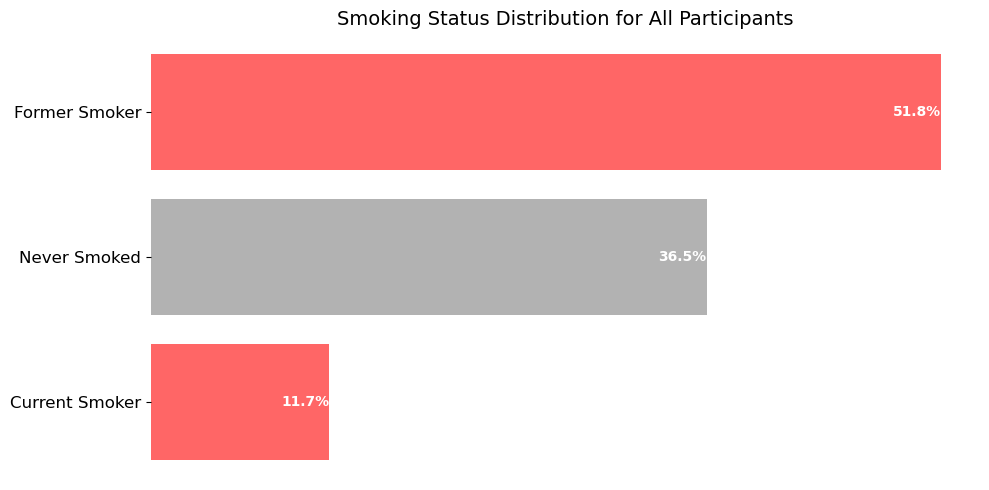

In [45]:
# Calculate counts and sort
smoke = df['cig_stat'].value_counts().sort_values()

# Define labels for smoking status
label = {0: "Never Smoked", 1: "Current Smoker", 2: "Former Smoker"}
smoke.index = smoke.index.map(label)

# Define colors: Red for "Current Smoker", grey for others
colors = ['grey' if label == "Never Smoked" else 'red' for label in smoke.index]

# Create the bar plot
plt.figure(figsize=(10, 5))  # Define figure size
plt.barh(smoke.index, smoke.values, color=colors, alpha=0.6)

# Add text annotations inside the bars
for i, (label, value) in enumerate(smoke.items()):
    percentage = f"{value / smoke.sum() * 100:.1f}%"  # Calculate percentage
    plt.text(value, i, percentage, color='white', va='center', fontweight='bold', fontsize=10, horizontalalignment='right')

# Formatting details
plt.title('Smoking Status Distribution for All Participants', fontsize=14)  # Set the plot title
plt.gca().spines['top'].set_visible(False)  # Hide the top spine
plt.gca().spines['right'].set_visible(False)  # Hide the right spine
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)# Optionally, hide the left spine

# Remove x-axis labels
plt.gca().xaxis.set_major_locator(plt.NullLocator())  # No x-ticks
plt.gca().xaxis.set_major_formatter(plt.NullFormatter())  # No x-tick labels

# Set y-tick label size
plt.gca().yaxis.set_tick_params(labelsize=12)  # Bigger font size for y-ticks

plt.tight_layout()  # Adjust layout to fit the figure area
plt.show()

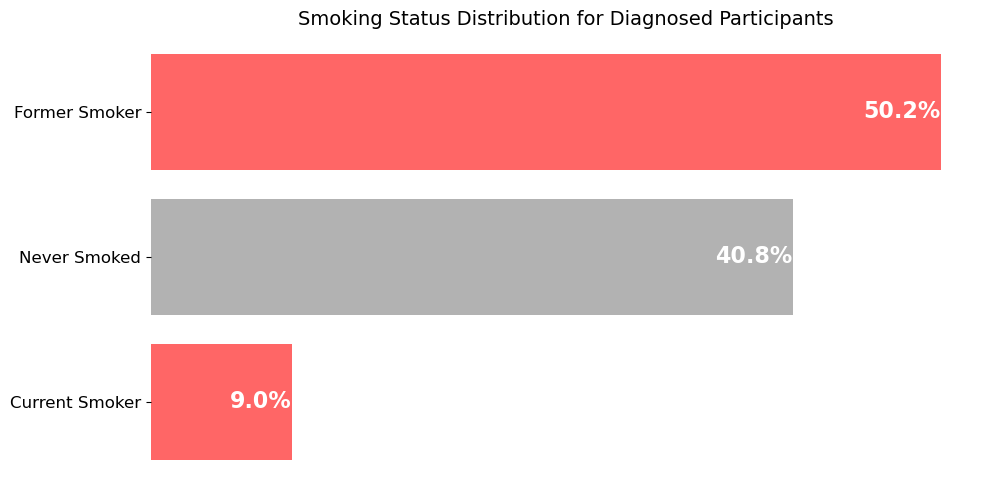

In [46]:
# Calculate counts and sort
smoke = df_c['cig_stat'].value_counts().sort_values()

# Define labels for smoking status
label = {0: "Never Smoked", 1: "Current Smoker", 2: "Former Smoker"}
smoke.index = smoke.index.map(label)

# Define colors: Red for "Current Smoker", grey for others
colors = ['grey' if label == "Never Smoked" else 'red' for label in smoke.index]

# Create the bar plot
plt.figure(figsize=(10, 5))  # Define figure size
plt.barh(smoke.index, smoke.values, color=colors, alpha=0.6)

# Add text annotations inside the bars
for i, (label, value) in enumerate(smoke.items()):
    percentage = f"{value / smoke.sum() * 100:.1f}%"  # Calculate percentage
    plt.text(value, i, percentage, color='white', va='center', fontweight='bold', fontsize=16, horizontalalignment='right')

# Formatting details
plt.title('Smoking Status Distribution for Diagnosed Participants', fontsize=14)  # Set the plot title
plt.gca().spines['top'].set_visible(False)  # Hide the top spine
plt.gca().spines['right'].set_visible(False)  # Hide the right spine
plt.gca().spines['left'].set_visible(False)  # Optionally, hide the left spine
plt.gca().spines['bottom'].set_visible(False)

# Remove x-axis labels
plt.gca().xaxis.set_major_locator(plt.NullLocator())  # No x-ticks
plt.gca().xaxis.set_major_formatter(plt.NullFormatter())  # No x-tick labels

# Set y-tick label size
plt.gca().yaxis.set_tick_params(labelsize=12)  # Bigger font size for y-ticks

plt.tight_layout()  # Adjust layout to fit the figure area
plt.show()

## PSA 

- Patients were included in the analysis if they had no previous history of prostate cancer and had PSA results spanning at least 4 yr before biopsy, with a minimum of two PSA tests in that time. All patients had an associated biopsy-confirmed outcome in the 12 mo following the last recorded PSA value. The model was trained using data consisting of a random selection of 80% of each individual data set. A final validation set was created by reserving 20% of each data set through random selection. In total, 10 719 patients met the criteria for inclusion.
---
- Low Risk (<4)
- Medium Risk (4-10)
- High Risk (>10)

Source: Advancing Traditional Prostate-specific Antigen Kinetics in the Detection of Prostate Cancer: A Machine Learning Model

source: https://www.cancer.org/cancer/types/prostate-cancer/detection-diagnosis-staging/how-diagnosed.html

In [47]:
df['psa_level0'].describe()

count    34123.000000
mean         1.928216
std         10.225142
min          0.000000
25%          0.660000
50%          1.130000
75%          2.040000
max       1137.500000
Name: psa_level0, dtype: float64

In [48]:
df_test = df[df['psa_level0']>50]
df_test.shape

(27, 21)

In [49]:
conditions = [
    (df['psa_level0'] < 4),
    (df['psa_level0'] >= 4) & (df['psa_level0'] <= 10),
    (df['psa_level0'] > 10)
]

# Define the corresponding categories
categories = ['Low Risk', 'Intermediate Risk', 'High Risk']

# Create a new column based on the conditions and categories
df['psa_risk_level'] = pd.Categorical(np.select(conditions, categories, default='Unknown'), categories=categories)

In [50]:
df[['psa_level0','psa_risk_level']].head(3)

,psa_level0,psa_risk_level
0,1.57,Low Risk
1,0.73,Low Risk
2,NaN,NaN


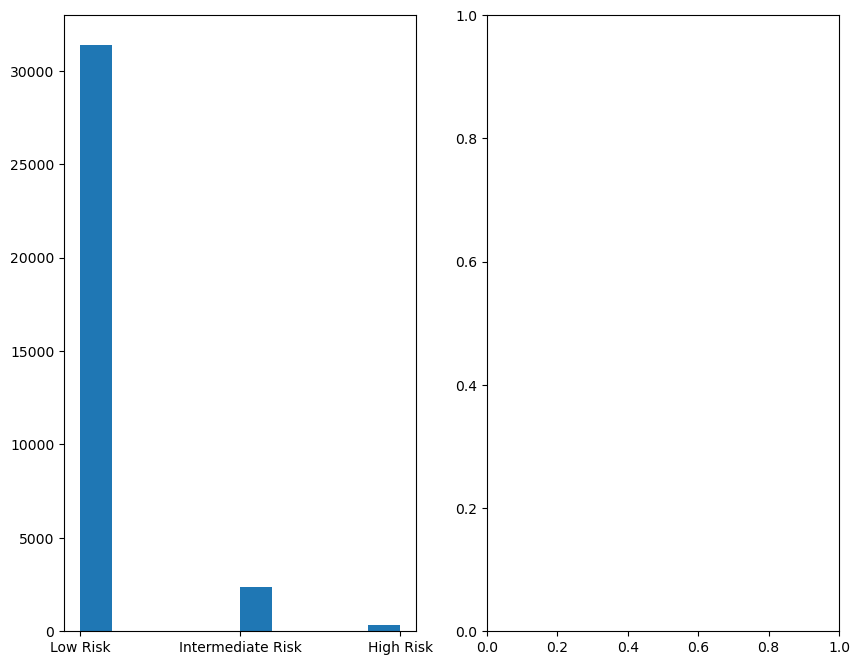

In [51]:
psa = df['psa_risk_level'].dropna()

fig, ax = plt.subplots(ncols=2, nrows=1,figsize=(10,8))

ax[0].hist(psa)
plt.show()

## PROS Stage

In [52]:
pros_eda = [
    #bq var
    "age", 
    "agelevel",
    "race7",
    "height_f",
    "weight_f",
    "bmi_curr",
    "educat",
    "cig_stat",
    #pros related var
    "ph_pros_trial",
    "pros_exitstat",
    "pros_exitdays",
    "pros_mra_stat1",
    "pros_mra_stat2",
    "pros_mra_stat3",
    "pros_mra_stat4",
    "pros_mra_stat5",
    "pros_cancer",
    "pros_cancer_first",
    "pros_annyr",
    "pros_stage",
    "pros_stage_m",
    "pros_stage_n",
    "pros_stage_t",
    "pros_clinstage",
    "pros_clinstage_m",
    "pros_clinstage_n",
    "pros_clinstage_t",
    "pros_pathstage",
    "pros_pathstage_m",
    "pros_pathstage_n",
    "pros_pathstage_t",
    "pros_stage_7e",
    "pros_clinstage_7e",
    "pros_pathstage_7e",
    "pros_gleason",
    "pros_gleason_biop",
    "pros_gleason_prost",
    "pros_gleason_source",
    "pros_grade",
    "pros_dx_psa",
    "pros_dx_psa_gap",
    "pros_behavior",
    "pros_topography",
    "pros_seer",
    "curative_prostp",
    "pros_fh",
    "pros_fh_age",
    "pros_fh_cnt",
    "enlpros_f",
    "enlprosa",
    "infpros_f",
    "infprosa",
    "prosprob_f",
    "surg_prostatectomy"
]

In [53]:
pros = raw[pros_eda]
nulls_info(pros)

,Total,Percent,DataType
pros_pathstage,73506,95.9,float64
pros_pathstage_7e,73506,95.9,float64
pros_gleason_prost,73483,95.8,float64
pros_pathstage_n,73469,95.8,float64
pros_pathstage_t,73464,95.8,float64
pros_pathstage_m,73463,95.8,float64
infprosa,71501,93.2,float64
pros_fh_age,71485,93.2,float64
pros_dx_psa,68419,89.2,float64
pros_dx_psa_gap,68419,89.2,float64


In [54]:
pros = raw[pros_eda]
pros = pros.dropna(axis=1, thresh=len(raw) * 0.4) 
print(f"Rows: {raw_reduced.shape[0]} | Cols: {raw_reduced.shape[1]}")

Rows: 76678 | Cols: 156


Curious about if the guys get high BMI, will it brings more possible to diagnose the prostate cancer compare to non-diagnosed guys. Classify BMI by CDC reference: https://www.cdc.gov/obesity/basics/adult-defining.html#:~:text=Adult%20Body%20Mass%20Index&text=If%20your%20BMI%20is%20less,falls%20within%20the%20obesity%20range.

In [55]:
bmi_threshold = [
    (pros['bmi_curr'] < 18.5),
    (pros['bmi_curr'] >= 18.5) & (pros['bmi_curr'] < 25),
    (pros['bmi_curr'] >= 25) & (pros['bmi_curr'] < 30),
    (pros['bmi_curr'] >= 30)
]

# Define the corresponding categories
categories = ['under weight', 'healthy weight', 'over weight', 'obesity']

# Create a new column based on the conditions and categories
pros['bmi_level'] = pd.Categorical(np.select(bmi_threshold, categories, default='Unknown'), categories=categories)
pros[['bmi_curr','bmi_level']].head(3)

,bmi_curr,bmi_level
0,25.724339,over weight
1,25.659988,over weight
2,34.585201,obesity


In [56]:
bmi_threshold = [
    (pros['bmi_curr'] < 18.5),
    (pros['bmi_curr'] >= 18.5) & (pros['bmi_curr'] < 25),
    (pros['bmi_curr'] >= 25) & (pros['bmi_curr'] < 30),
    (pros['bmi_curr'] >= 30)
]

# Define the corresponding categories
categories = ['under weight', 'healthy weight', 'over weight', 'obesity']

# Create a new column based on the conditions and categories
pros['bmi_level'] = pd.Categorical(np.select(bmi_threshold, categories, default='Unknown'), categories=categories)
pros[['bmi_curr','bmi_level']].head(3)

,bmi_curr,bmi_level
0,25.724339,over weight
1,25.659988,over weight
2,34.585201,obesity


In [57]:
#split dataset
diagnosed = pros[pros['pros_cancer']== 1]
not_diagnosed = pros[pros['pros_cancer']== 0]

In [58]:
#only focus on someone diagnosed
diagnosed

,age,agelevel,race7,height_f,weight_f,bmi_curr,educat,cig_stat,ph_pros_trial,pros_exitstat,...,pros_mra_stat4,pros_mra_stat5,pros_cancer,pros_fh,pros_fh_cnt,enlpros_f,infpros_f,prosprob_f,surg_prostatectomy,bmi_level
5,56,0,1,69.0,210.0,31.008192,4.0,1.0,0,1,...,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,obesity
8,67,2,1,70.0,170.0,24.389796,6.0,0.0,0,1,...,0,0,1,0.0,0.0,1.0,0.0,1.0,0.0,healthy weight
10,67,2,4,66.0,143.0,23.078283,7.0,0.0,0,1,...,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,healthy weight
12,56,0,2,67.0,170.0,26.622856,6.0,0.0,0,1,...,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,over weight
15,65,2,1,70.0,238.0,34.145714,7.0,0.0,0,1,...,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,obesity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76646,69,2,1,75.0,225.0,28.120000,2.0,2.0,0,1,...,0,0,1,0.0,0.0,0.0,NaN,0.0,0.0,over weight
76647,72,3,1,69.0,165.0,24.363579,7.0,0.0,0,1,...,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,healthy weight
76666,55,0,1,74.0,178.0,22.851351,7.0,2.0,0,1,...,0,0,1,1.0,1.0,1.0,1.0,1.0,0.0,healthy weight
76667,68,2,1,67.0,168.0,26.309646,3.0,2.0,0,1,...,0,0,1,0.0,0.0,0.0,NaN,0.0,0.0,over weight


In [59]:
# calculate data missing rate again, this time better!

nulls_info(diagnosed)

,Total,Percent,DataType
infpros_f,1902,21.7,float64
surg_prostatectomy,498,5.7,float64
bmi_level,385,4.4,category
bmi_curr,385,4.4,float64
height_f,323,3.7,float64
weight_f,323,3.7,float64
pros_fh_cnt,299,3.4,float64
pros_fh,299,3.4,float64
prosprob_f,257,2.9,float64
educat,256,2.9,float64


In [60]:
pd.set_option('display.max_columns', None)
display(diagnosed.describe())

,age,agelevel,race7,height_f,weight_f,bmi_curr,educat,cig_stat,ph_pros_trial,pros_exitstat,pros_exitdays,pros_mra_stat1,pros_mra_stat2,pros_mra_stat3,pros_mra_stat4,pros_mra_stat5,pros_cancer,pros_fh,pros_fh_cnt,enlpros_f,infpros_f,prosprob_f,surg_prostatectomy
count,8776.000000,8776.000000,8776.000000,8453.000000,8453.000000,8391.000000,8520.000000,8536.000000,8776.0,8776.0,8776.000000,8776.000000,8776.000000,8776.000000,8776.000000,8776.000000,8776.0,8477.000000,8477.000000,8524.000000,6874.000000,8519.000000,8278.000000
mean,63.508432,1.327940,1.368277,70.058441,190.336449,27.225603,4.936150,1.094892,0.0,1.0,2193.530082,0.177758,0.161577,0.142890,0.067799,0.082726,1.0,0.253392,0.117966,0.261028,0.101688,0.300153,0.003382
std,5.076053,0.987684,1.164710,2.685281,30.478098,3.892160,1.650722,0.949525,0.0,0.0,1412.282117,0.456757,0.432430,0.404366,0.284181,0.304560,0.0,1.163169,0.356963,0.439221,0.302259,0.458351,0.058064
min,54.000000,0.000000,1.000000,49.000000,105.000000,15.830362,1.000000,0.000000,0.0,1.0,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,1.000000,1.000000,68.000000,170.000000,24.409722,3.000000,0.000000,0.0,1.0,937.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,63.000000,1.000000,1.000000,70.000000,185.000000,26.605753,5.000000,2.000000,0.0,1.0,2121.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,67.000000,2.000000,1.000000,72.000000,209.000000,29.285856,6.000000,2.000000,0.0,1.0,3337.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,74.000000,3.000000,7.000000,83.000000,390.000000,66.171595,7.000000,2.000000,0.0,1.0,5817.000000,3.000000,3.000000,3.000000,3.000000,3.000000,1.0,9.000000,4.000000,1.000000,1.000000,1.000000,1.000000


In [61]:
diagnosed['bmi_level']

5               obesity
8        healthy weight
10       healthy weight
12          over weight
15              obesity
              ...      
76646       over weight
76647    healthy weight
76666    healthy weight
76667       over weight
76676       over weight
Name: bmi_level, Length: 8776, dtype: category
Categories (4, object): ['under weight', 'healthy weight', 'over weight', 'obesity']

In [62]:
not_diagnosed['bmi_level']

0           over weight
1           over weight
2               obesity
3        healthy weight
4               obesity
              ...      
76672    healthy weight
76673       over weight
76674    healthy weight
76675       over weight
76677           obesity
Name: bmi_level, Length: 67902, dtype: category
Categories (4, object): ['under weight', 'healthy weight', 'over weight', 'obesity']

In [63]:
bmi_diag_counts = diagnosed['bmi_level'].value_counts().dropna()
bmi_diag_counts

over weight       4311
healthy weight    2379
obesity           1680
under weight        21
Name: bmi_level, dtype: int64

In [64]:
bmi_nondiag_counts = not_diagnosed['bmi_level'].value_counts().dropna()
bmi_nondiag_counts

over weight       32253
healthy weight    16961
obesity           14790
under weight        241
Name: bmi_level, dtype: int64

In [65]:
dia_bmi_freq = diagnosed['bmi_level'].value_counts()
nondia_bmi_freq = not_diagnosed['bmi_level'].value_counts()

print(dia_bmi_freq,nondia_bmi_freq)

over weight       4311
healthy weight    2379
obesity           1680
under weight        21
Name: bmi_level, dtype: int64 over weight       32253
healthy weight    16961
obesity           14790
under weight        241
Name: bmi_level, dtype: int64


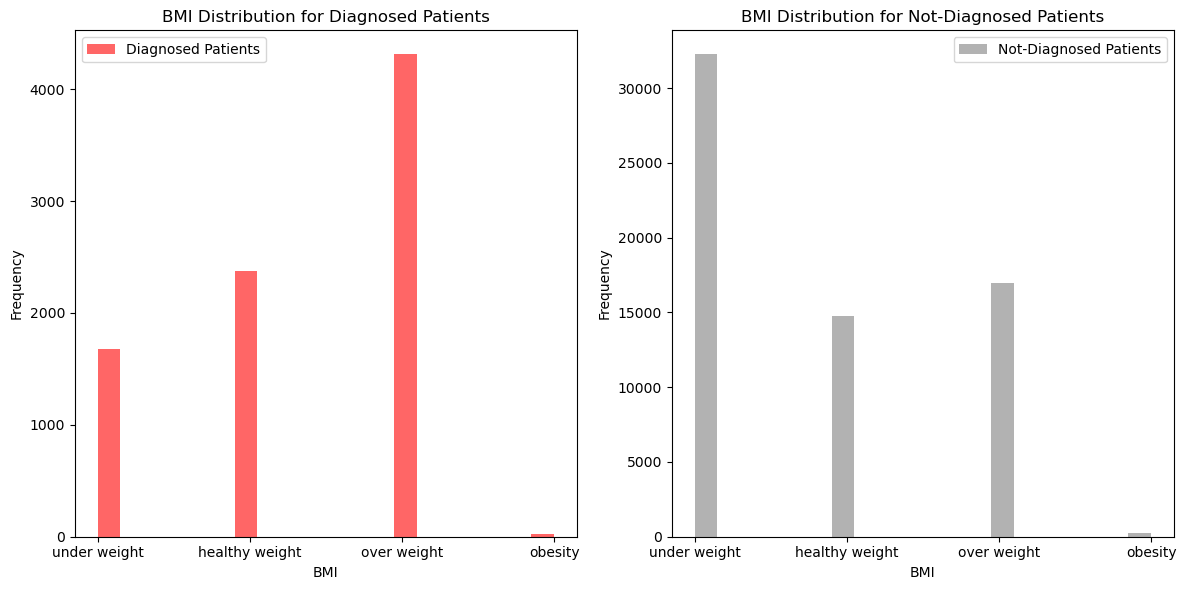

In [90]:
# Define the order of categories for the x-axis
categories = ['under weight', 'healthy weight', 'over weight', 'obesity']

bmi_diag = diagnosed['bmi_level'].dropna()
bmi_nondiag = not_diagnosed['bmi_level'].dropna()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

# Plot for diagnosed patients
n_diag, bins_diag, patches_diag = ax[0].hist(bmi_diag, bins=20, color='red', alpha=0.6, label='Diagnosed Patients')
ax[0].set_title('BMI Distribution for Diagnosed Patients')
ax[0].set_xlabel('BMI')
ax[0].set_ylabel('Frequency')
ax[0].legend()
ax[0].grid(False)


# Set x-axis labels for diagnosed patients
ax[0].set_xticks(range(len(categories)))
ax[0].set_xticklabels(categories)

# Plot for not-diagnosed patients
n_nondiag, bins_nondiag, patches_nondiag = ax[1].hist(bmi_nondiag, bins=20, color='grey', alpha=0.6, label='Not-Diagnosed Patients')
ax[1].set_title('BMI Distribution for Not-Diagnosed Patients')
ax[1].set_xlabel('BMI')
ax[1].set_ylabel('Frequency')
ax[1].legend()
ax[1].grid(False)

# Set x-axis labels for not-diagnosed patients
ax[1].set_xticks(range(len(categories)))
ax[1].set_xticklabels(categories)

plt.tight_layout()
plt.show()

In [77]:
# Calculate percentages for diagnosed and not-diagnosed BMI categories
total_diag = dia_bmi_freq.sum()
percentages_diag = (dia_bmi_freq / total_diag * 100).round(2)

total_nondiag = nondia_bmi_freq.sum()
percentages_nondiag = (nondia_bmi_freq / total_nondiag * 100).round(2)


In [93]:
print(percentages_diag, percentages_nondiag)

[0.25, 28.35, 51.38, 20.02] [0.38, 26.4, 50.2, 23.02]


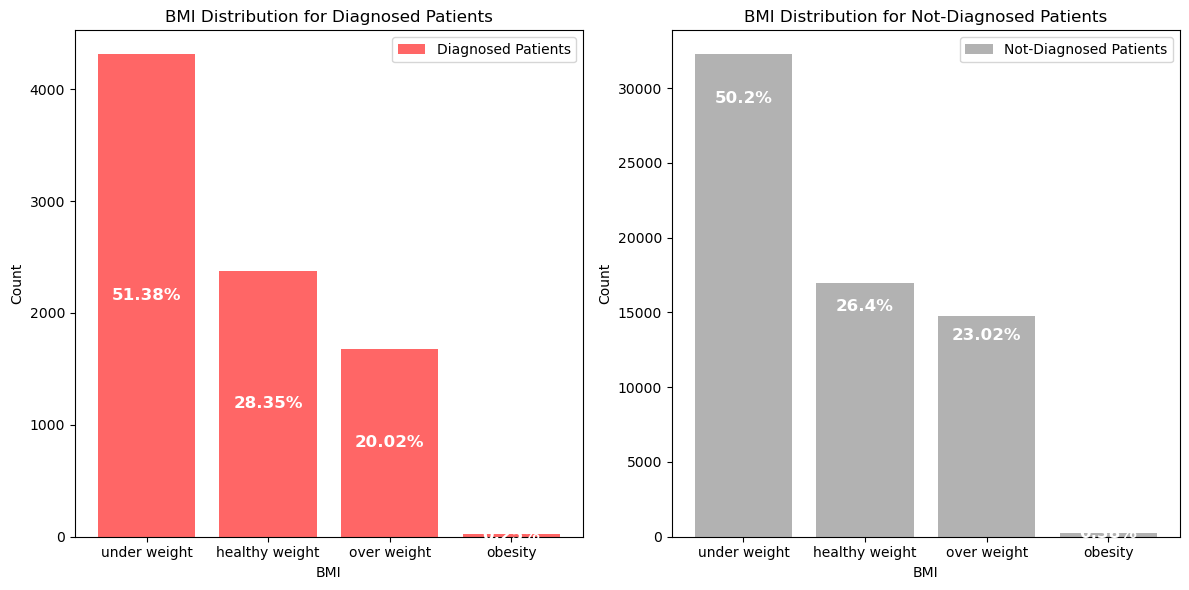

In [79]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

# Plot for diagnosed patients
bars_diag = ax[0].bar(categories, dia_bmi_freq, color='red', alpha=0.6, label='Diagnosed Patients')

# Add text annotations inside the bars with percentages for diagnosed patients
for bar, percentage in zip(bars_diag, percentages_diag):
    yval = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2, yval / 2, f'{percentage}%', ha='center', va='center', color='white', fontsize=12, fontweight='bold')

ax[0].set_title('BMI Distribution for Diagnosed Patients')
ax[0].set_xlabel('BMI')
ax[0].set_ylabel('Count')
ax[0].legend()
ax[0].grid(False)

# Plot for not-diagnosed patients
bars_nondiag = ax[1].bar(categories, nondia_bmi_freq, color='grey', alpha=0.6, label='Not-Diagnosed Patients')

# Add text annotations inside the bars with percentages for not-diagnosed patients
for bar, percentage in zip(bars_nondiag, percentages_nondiag):
    yval = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2, yval / 1.1, f'{percentage}%', ha='center', va='center', color='white', fontsize=12, fontweight='bold')

ax[1].set_title('BMI Distribution for Not-Diagnosed Patients')
ax[1].set_xlabel('BMI')
ax[1].set_ylabel('Count')
ax[1].legend()
ax[1].grid(False)

plt.tight_layout()
plt.show()


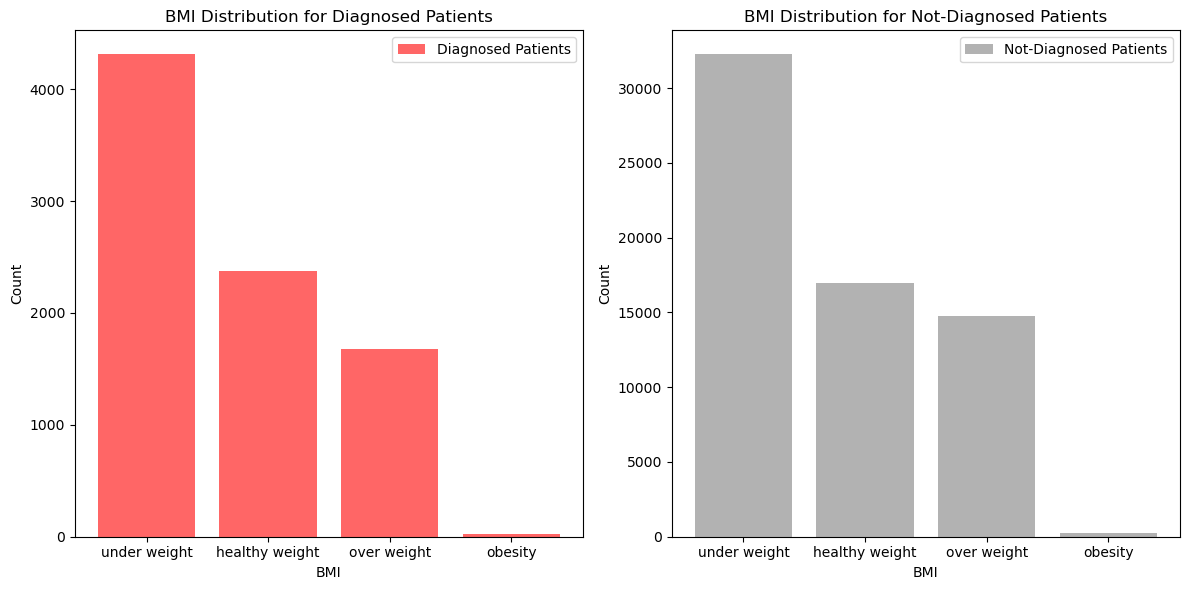

In [80]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

# Plot for diagnosed patients
bars_diag = ax[0].bar(categories, dia_bmi_freq, color='red', alpha=0.6, label='Diagnosed Patients')

# Add text annotations inside the bars with percentages for diagnosed patients
for bar, percentage in zip(bars_diag, percentages_diag):
    yval = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2, yval, f'{percentage}%', ha='center', va='bottom', color='white', fontsize=12, fontweight='bold')

ax[0].set_title('BMI Distribution for Diagnosed Patients')
ax[0].set_xlabel('BMI')
ax[0].set_ylabel('Count')
ax[0].legend()
ax[0].grid(False)

# Plot for not-diagnosed patients
bars_nondiag = ax[1].bar(categories, nondia_bmi_freq, color='grey', alpha=0.6, label='Not-Diagnosed Patients')

# Add text annotations inside the bars with percentages for not-diagnosed patients
for bar, percentage in zip(bars_nondiag, percentages_nondiag):
    yval = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2, yval, f'{percentage}%', ha='center', va='bottom', color='white', fontsize=12, fontweight='bold')

ax[1].set_title('BMI Distribution for Not-Diagnosed Patients')
ax[1].set_xlabel('BMI')
ax[1].set_ylabel('Count')
ax[1].legend()
ax[1].grid(False)

plt.tight_layout()
plt.show()


In [81]:
print("Diagnosed bar heights:", [bar.get_height() for bar in bars_diag])
print("Not-Diagnosed bar heights:", [bar.get_height() for bar in bars_nondiag])


Diagnosed bar heights: [4311, 2379, 1680, 21]
Not-Diagnosed bar heights: [32253, 16961, 14790, 241]


In [82]:
# Calculate percentages for diagnosed and not-diagnosed BMI categories
total_diag = dia_bmi_freq.sum()
percentages_diag = (dia_bmi_freq / total_diag * 100).round(2)

total_nondiag = nondia_bmi_freq.sum()
percentages_nondiag = (nondia_bmi_freq / total_nondiag * 100).round(2)

print("Diagnosed percentages:", percentages_diag)
print("Not-Diagnosed percentages:", percentages_nondiag)


Diagnosed percentages: over weight       51.38
healthy weight    28.35
obesity           20.02
under weight       0.25
Name: bmi_level, dtype: float64
Not-Diagnosed percentages: over weight       50.20
healthy weight    26.40
obesity           23.02
under weight       0.38
Name: bmi_level, dtype: float64


In [83]:
# Add text annotations inside the bars with percentages for diagnosed patients
for bar, percentage in zip(bars_diag, percentages_diag):
    yval = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2, yval / 1.1, f'{percentage}%', ha='center', va='center', color='white', fontsize=12, fontweight='bold')

# Add text annotations inside the bars with percentages for not-diagnosed patients
for bar, percentage in zip(bars_nondiag, percentages_nondiag):
    yval = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2, yval / 1.1, f'{percentage}%', ha='center', va='center', color='white', fontsize=12, fontweight='bold')


In [67]:
diagnosed['bmi_level'].count()

8391

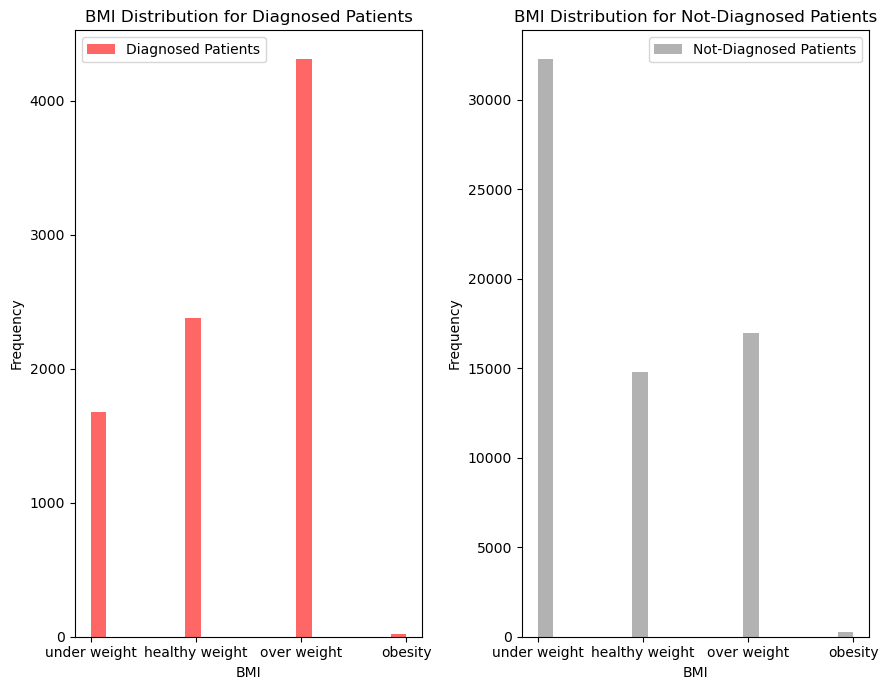

In [68]:
# Define the order of categories for the x-axis
categories = ['under weight', 'healthy weight', 'over weight', 'obesity']

bmi_diag = diagnosed['bmi_level'].dropna()
bmi_nondiag = not_diagnosed['bmi_level'].dropna()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(9, 7))

# Plot for diagnosed patients
ax[0].hist(bmi_diag, bins=20, color='red', alpha=0.6, label='Diagnosed Patients')
ax[0].set_title('BMI Distribution for Diagnosed Patients')
ax[0].set_xlabel('BMI')
ax[0].set_ylabel('Frequency')
ax[0].legend()
ax[0].grid(False)

# Set x-axis labels for diagnosed patients
ax[0].set_xticks(range(len(categories)))
ax[0].set_xticklabels(categories)

# Plot for not-diagnosed patients
ax[1].hist(bmi_nondiag, bins=20, color='grey', alpha=0.6, label='Not-Diagnosed Patients')
ax[1].set_title('BMI Distribution for Not-Diagnosed Patients')
ax[1].set_xlabel('BMI')
ax[1].set_ylabel('Frequency')
ax[1].legend()
ax[1].grid(False)

# Set x-axis labels for not-diagnosed patients
ax[1].set_xticks(range(len(categories)))
ax[1].set_xticklabels(categories)

plt.tight_layout()
plt.show()

In [69]:
diagnosed['surg_prostatectomy'].replace({0:"no", 1: 'yes'})
not_diagnosed['surg_prostatectomy'].replace({0:"no", 1: 'yes'})

0        no
1        no
2        no
3        no
4        no
         ..
76672    no
76673    no
76674    no
76675    no
76677    no
Name: surg_prostatectomy, Length: 67902, dtype: object

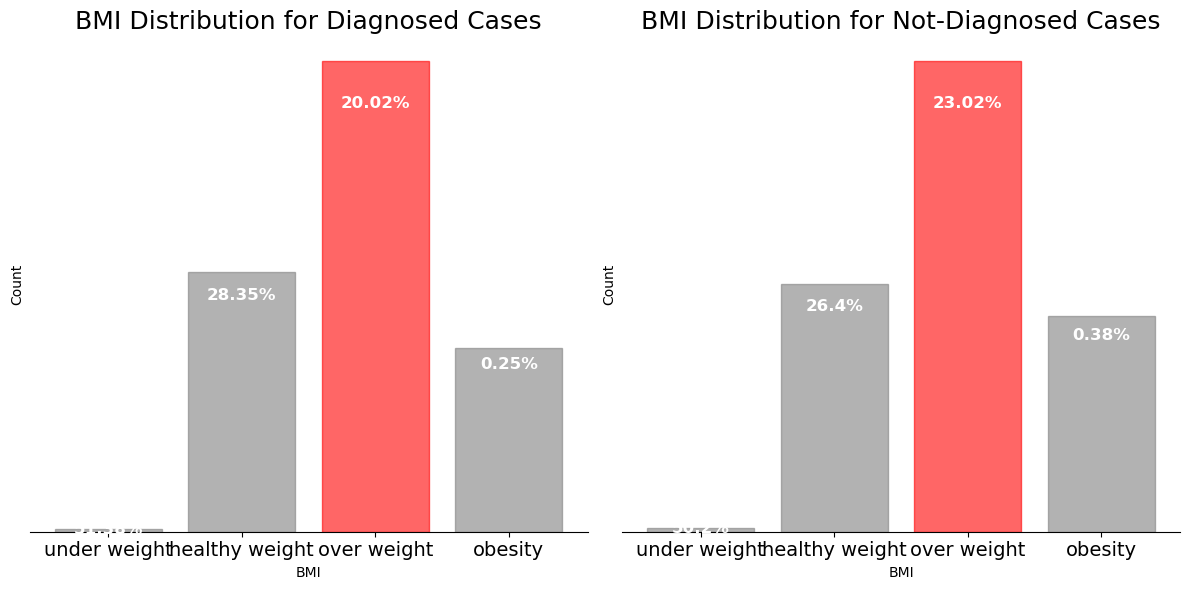

In [85]:
plt.figure(figsize=(10, 6))
max_value_nonbmi = percentages_nondiag.max()
colors_3 = ['red' if value == max_value_3 else 'grey' for value in agelevel_3.values]
bars = plt.bar(percentages_nondiag.index, height=percentages_nondiag.values, color=colors_3, alpha=0.6)

# Add text annotations inside the bars with percentages
for bar, percentage in zip(bars, percentages_3):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval / 1.1, f'{percentage}%', ha='center', va='center', color='white', fontsize=12, fontweight='bold')

plt.title('Age Distribution for Not Diagnosed Cases', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks([])  # Hide y-axis ticks
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.show()

In [108]:
# Print count of 'yes' and 'no' for diagnosed patients
print("Diagnosed Patients:")
print(diagnosed['surg_prostatectomy'].value_counts())

# Print count of 'yes' and 'no' for not-diagnosed patients
print("\nNot-Diagnosed Patients:")
print(not_diagnosed['surg_prostatectomy'].value_counts())

Diagnosed Patients:
0.0    8250
1.0      28
Name: surg_prostatectomy, dtype: int64

Not-Diagnosed Patients:
0.0    63010
1.0      192
Name: surg_prostatectomy, dtype: int64


Diagnosed Patients:
0.0    8250
1.0      28
Name: surg_prostatectomy, dtype: int64

Not-Diagnosed Patients:
0.0    63010
1.0      192
Name: surg_prostatectomy, dtype: int64


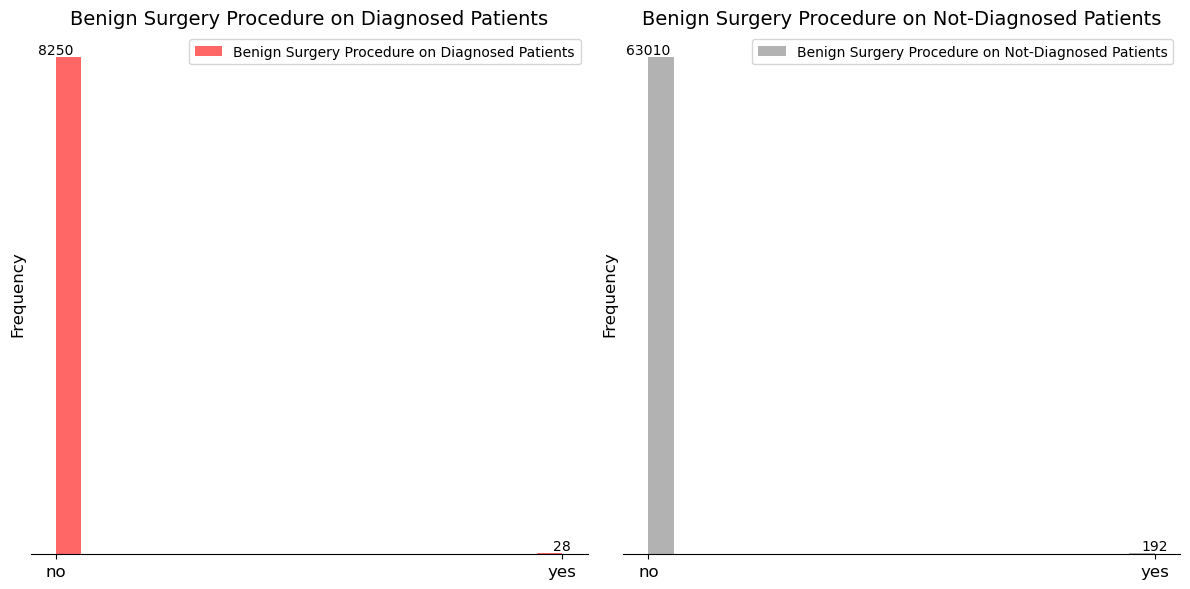

In [109]:
# Print count of 'yes' and 'no' for diagnosed patients
print("Diagnosed Patients:")
print(diagnosed['surg_prostatectomy'].value_counts())

# Print count of 'yes' and 'no' for not-diagnosed patients
print("\nNot-Diagnosed Patients:")
print(not_diagnosed['surg_prostatectomy'].value_counts())

# Define the order of categories for the x-axis
categories = ['no', 'yes']

benign_diag = diagnosed['surg_prostatectomy'].dropna()
benign_nondiag = not_diagnosed['surg_prostatectomy'].dropna()

# Create a function to format individual histogram plots
def format_hist_plot(ax, data, title, color):
    counts = data.value_counts()
    ax.hist(data, bins=20, color=color, alpha=0.6, label=title)  # Set alpha to 0.6 for stronger color
    ax.set_title(title, fontsize=14)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Remove y-axis labels
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_formatter(plt.NullFormatter())

    # Set x-tick labels
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories)

    # Set x-tick label size
    ax.xaxis.set_tick_params(labelsize=12)

    # Add text annotations on top of each bar
    for i, count in enumerate(counts):
        ax.text(i, count, str(count), ha='center', va='bottom', color='black', fontweight='normal')

# Create subplots
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

# Format and plot for diagnosed patients with a stronger red color
format_hist_plot(ax[0], benign_diag, 'Benign Surgery Procedure on Diagnosed Patients', 'red')

# Format and plot for not-diagnosed patients with a stronger grey color
format_hist_plot(ax[1], benign_nondiag, 'Benign Surgery Procedure on Not-Diagnosed Patients', 'grey')

plt.tight_layout()
plt.show()

In [110]:
column_names = diagnosed.columns.tolist()
print(column_names)

['age', 'agelevel', 'race7', 'height_f', 'weight_f', 'bmi_curr', 'educat', 'cig_stat', 'ph_pros_trial', 'pros_exitstat', 'pros_exitdays', 'pros_mra_stat1', 'pros_mra_stat2', 'pros_mra_stat3', 'pros_mra_stat4', 'pros_mra_stat5', 'pros_cancer', 'pros_fh', 'pros_fh_cnt', 'enlpros_f', 'infpros_f', 'prosprob_f', 'surg_prostatectomy', 'bmi_level']


In [111]:
diagnosed

,age,agelevel,race7,height_f,weight_f,bmi_curr,educat,cig_stat,ph_pros_trial,pros_exitstat,pros_exitdays,pros_mra_stat1,pros_mra_stat2,pros_mra_stat3,pros_mra_stat4,pros_mra_stat5,pros_cancer,pros_fh,pros_fh_cnt,enlpros_f,infpros_f,prosprob_f,surg_prostatectomy,bmi_level
5,56,0,1,69.0,210.0,31.008192,4.0,1.0,0,1,3342,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,obesity
8,67,2,1,70.0,170.0,24.389796,6.0,0.0,0,1,2003,0,0,0,0,0,1,0.0,0.0,1.0,0.0,1.0,0.0,healthy weight
10,67,2,4,66.0,143.0,23.078283,7.0,0.0,0,1,383,1,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,healthy weight
12,56,0,2,67.0,170.0,26.622856,6.0,0.0,0,1,2000,0,0,0,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,over weight
15,65,2,1,70.0,238.0,34.145714,7.0,0.0,0,1,3528,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,obesity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76646,69,2,1,75.0,225.0,28.120000,2.0,2.0,0,1,3949,0,0,0,0,0,1,0.0,0.0,0.0,NaN,0.0,0.0,over weight
76647,72,3,1,69.0,165.0,24.363579,7.0,0.0,0,1,2804,1,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,healthy weight
76666,55,0,1,74.0,178.0,22.851351,7.0,2.0,0,1,1806,0,0,0,0,0,1,1.0,1.0,1.0,1.0,1.0,0.0,healthy weight
76667,68,2,1,67.0,168.0,26.309646,3.0,2.0,0,1,1586,0,0,0,0,0,1,0.0,0.0,0.0,NaN,0.0,0.0,over weight


age                  NaN
agelevel             NaN
race7                NaN
height_f             NaN
weight_f             NaN
bmi_curr             NaN
educat               NaN
cig_stat             NaN
ph_pros_trial        NaN
pros_exitstat        NaN
pros_exitdays        NaN
pros_mra_stat1       NaN
pros_mra_stat2       NaN
pros_mra_stat3       NaN
pros_mra_stat4       NaN
pros_mra_stat5       NaN
pros_fh              NaN
pros_fh_cnt          NaN
enlpros_f            NaN
infpros_f            NaN
prosprob_f           NaN
surg_prostatectomy   NaN
pros_cancer          NaN
Name: pros_cancer, dtype: float64


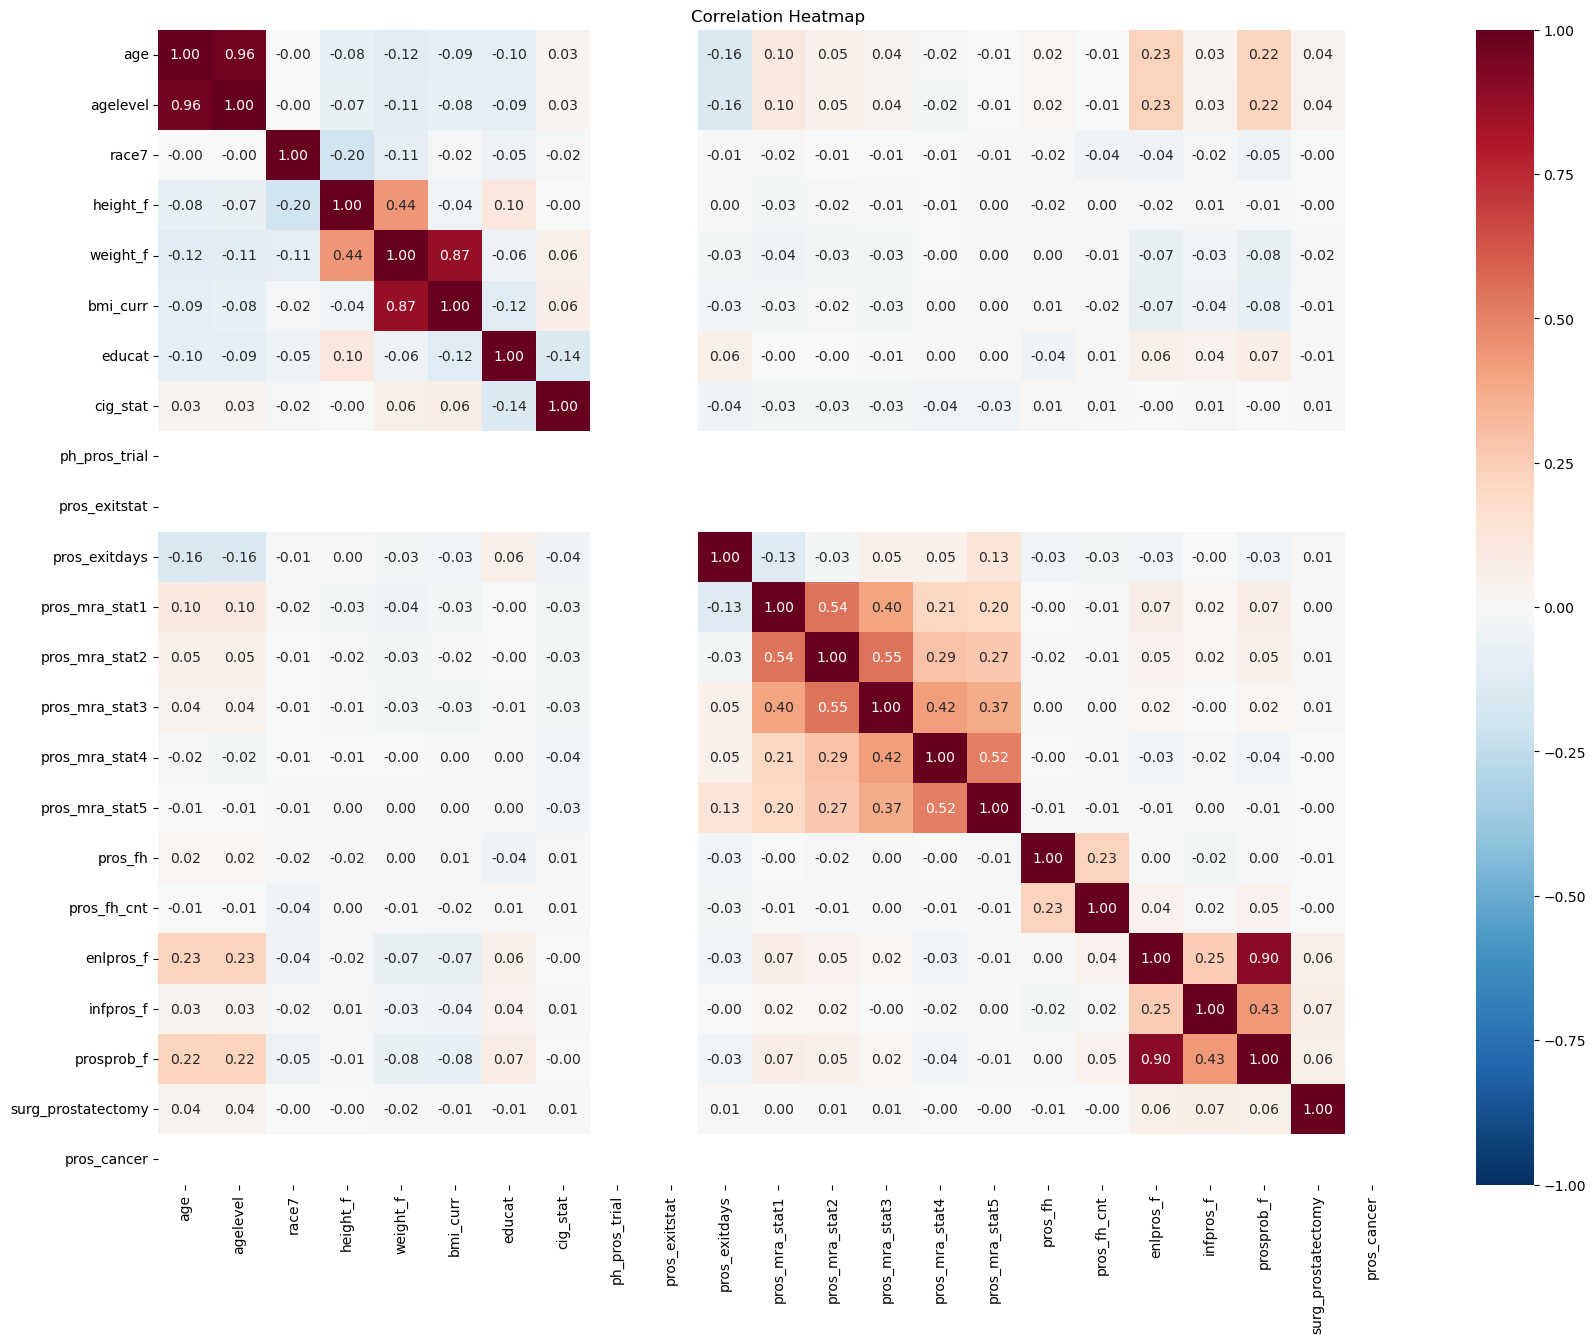

In [112]:
# Define the columns
columns = ['age', 'agelevel', 'race7', 'height_f', 'weight_f', 'bmi_curr',
    'educat', 'cig_stat', 'ph_pros_trial', 'pros_exitstat', 'pros_exitdays',
    'pros_mra_stat1', 'pros_mra_stat2', 'pros_mra_stat3', 'pros_mra_stat4',
    'pros_mra_stat5', 'pros_fh', 'pros_fh_cnt', 'enlpros_f', 'infpros_f',
    'prosprob_f', 'surg_prostatectomy', 'pros_cancer']

# Create a subset DataFrame with the selected columns
correlation_data = diagnosed[columns]

# Convert columns to numeric and handle errors by coercing to NaN
correlation_data = correlation_data.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values
correlation_data.dropna(inplace=True)

# Calculate correlation matrix
corr_matrix = correlation_data.corr()

# Print correlation values with respect to pros_cancer
print(corr_matrix['pros_cancer'].sort_values(ascending=False))

# Plot correlation heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', vmin=-1, vmax=1, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Diagnosed Patients:
0.0    6299
1.0    2225
Name: enlpros_f, dtype: int64

Not-Diagnosed Patients:
0.0    51347
1.0    13846
Name: enlpros_f, dtype: int64


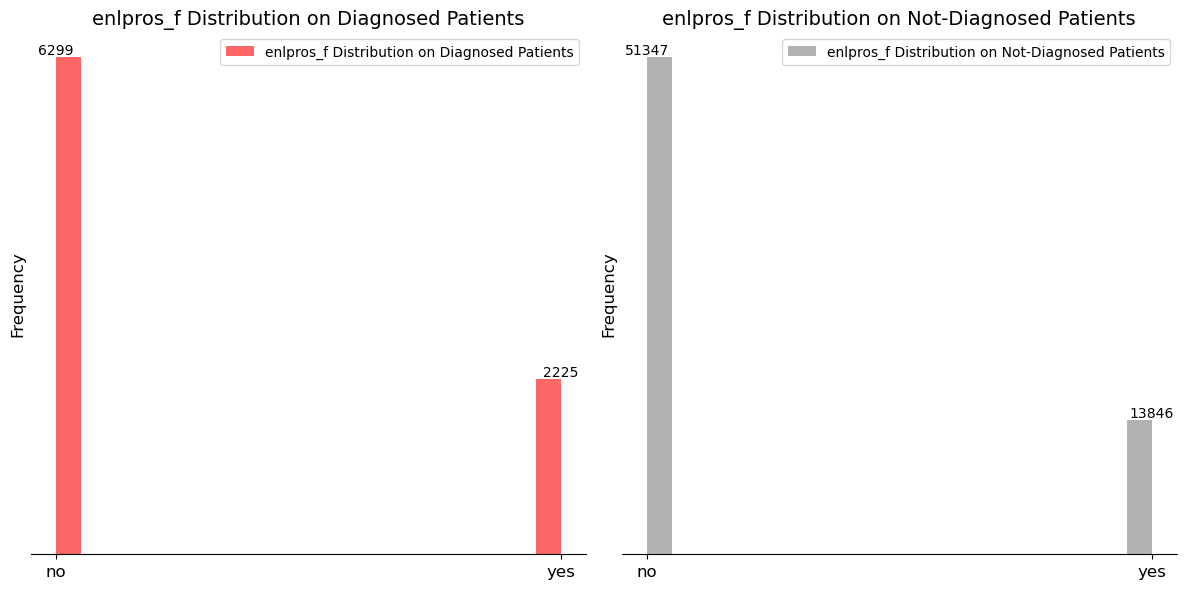

In [113]:
# Print count of 'yes' and 'no' for diagnosed patients
print("Diagnosed Patients:")
print(diagnosed['enlpros_f'].value_counts())

# Print count of 'yes' and 'no' for not-diagnosed patients
print("\nNot-Diagnosed Patients:")
print(not_diagnosed['enlpros_f'].value_counts())

# Define the order of categories for the x-axis
categories = ['no', 'yes']

enlpros_diag = diagnosed['enlpros_f'].dropna()
enlpros_nondiag = not_diagnosed['enlpros_f'].dropna()

# Create a function to format individual histogram plots
def format_hist_plot(ax, data, title, color):
    counts = data.value_counts()
    ax.hist(data, bins=20, color=color, alpha=0.6, label=title)  # Set alpha to 0.6 for stronger color
    ax.set_title(title, fontsize=14)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Remove y-axis labels
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_formatter(plt.NullFormatter())

    # Set x-tick labels
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories)

    # Set x-tick label size
    ax.xaxis.set_tick_params(labelsize=12)

    # Add text annotations on top of each bar
    for i, count in enumerate(counts):
        ax.text(i, count, str(count), ha='center', va='bottom', color='black', fontweight='normal')

# Create subplots
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

# Format and plot for diagnosed patients with a stronger red color
format_hist_plot(ax[0], enlpros_diag, 'enlpros_f Distribution on Diagnosed Patients', 'red')

# Format and plot for not-diagnosed patients with a stronger grey color
format_hist_plot(ax[1], enlpros_nondiag, 'enlpros_f Distribution on Not-Diagnosed Patients', 'grey')

plt.tight_layout()
plt.show()

Diagnosed Patients:
0.0    5962
1.0    2557
Name: prosprob_f, dtype: int64

Not-Diagnosed Patients:
0.0    49066
1.0    16103
Name: prosprob_f, dtype: int64


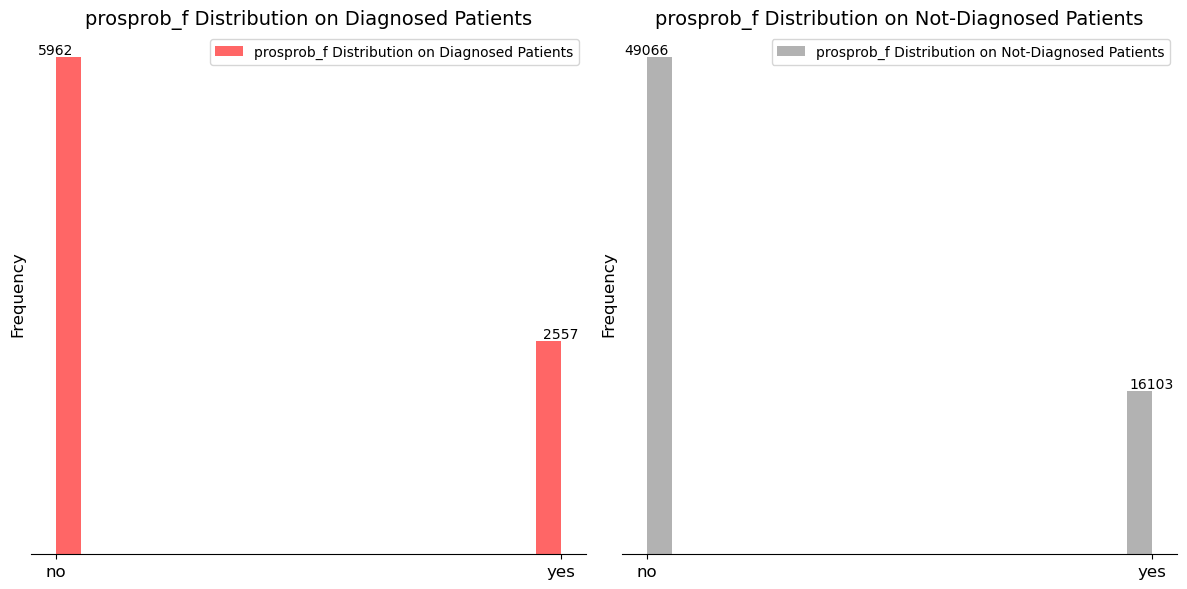

In [114]:
# Print count of 'yes' and 'no' for diagnosed patients
print("Diagnosed Patients:")
print(diagnosed['prosprob_f'].value_counts())

# Print count of 'yes' and 'no' for not-diagnosed patients
print("\nNot-Diagnosed Patients:")
print(not_diagnosed['prosprob_f'].value_counts())

# Define the order of categories for the x-axis
categories = ['no', 'yes']

prosprob_diag = diagnosed['prosprob_f'].dropna()
prosprob_nondiag = not_diagnosed['prosprob_f'].dropna()

# Create a function to format individual histogram plots
def format_hist_plot(ax, data, title, color):
    counts = data.value_counts()
    ax.hist(data, bins=20, color=color, alpha=0.6, label=title)  # Set alpha to 0.6 for stronger color
    ax.set_title(title, fontsize=14)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Remove y-axis labels
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_formatter(plt.NullFormatter())

    # Set x-tick labels
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories)

    # Set x-tick label size
    ax.xaxis.set_tick_params(labelsize=12)

    # Add text annotations on top of each bar
    for i, count in enumerate(counts):
        ax.text(i, count, str(count), ha='center', va='bottom', color='black', fontweight='normal')

# Create subplots
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

# Format and plot for diagnosed patients with a stronger red color
format_hist_plot(ax[0], prosprob_diag, 'prosprob_f Distribution on Diagnosed Patients', 'red')

# Format and plot for not-diagnosed patients with a stronger grey color
format_hist_plot(ax[1], prosprob_nondiag, 'prosprob_f Distribution on Not-Diagnosed Patients', 'grey')

plt.tight_layout()
plt.show()

In [115]:
# Calculate the percentage of 'yes' for 'prosprob_f' in diagnosed patients
diag_counts = diagnosed['prosprob_f'].value_counts(normalize=True) * 100

# Calculate the percentage of 'yes' for 'prosprob_f' in not-diagnosed patients
nondiag_counts = not_diagnosed['prosprob_f'].value_counts(normalize=True) * 100

print("Percentage of 'yes' for prosprob_f in Diagnosed Patients:")
print(diag_counts)

print("\nPercentage of 'yes' for prosprob_f in Not-Diagnosed Patients:")
print(nondiag_counts)


Percentage of 'yes' for prosprob_f in Diagnosed Patients:
0.0    69.98474
1.0    30.01526
Name: prosprob_f, dtype: float64

Percentage of 'yes' for prosprob_f in Not-Diagnosed Patients:
0.0    75.290399
1.0    24.709601
Name: prosprob_f, dtype: float64


In [116]:
# Calculate total for diagnosed and not diagnosed
total_diagnosed = diagnosed['age'].sum()
total_not_diagnosed = not_diagnosed['age'].sum()

# Calculate percentages
percentages_diagnosed = (df['diagnosed'] / total_diagnosed * 100).round(2)
percentages_not_diagnosed = (df['not_diagnosed'] / total_not_diagnosed * 100).round(2)

# Create the plot
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Plot for diagnosed data
bars1 = ax[0].bar(df.index, df['diagnosed'], color='blue', alpha=0.6)

# Add text annotations inside the bars for diagnosed data
for bar, percentage in zip(bars1, percentages_diagnosed):
    yval = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2, yval / 2, f'{percentage}%', ha='center', va='center', color='white', fontsize=12, fontweight='bold')

ax[0].set_title('Diagnosed Age Distribution', fontsize=16)
ax[0].set_xlabel('Age Group', fontsize=14)
ax[0].set_ylabel('Count', fontsize=14)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

# Plot for not diagnosed data
bars2 = ax[1].bar(df.index, df['not_diagnosed'], color='red', alpha=0.6)

# Add text annotations inside the bars for not diagnosed data
for bar, percentage in zip(bars2, percentages_not_diagnosed):
    yval = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2, yval / 2, f'{percentage}%', ha='center', va='center', color='white', fontsize=12, fontweight='bold')

ax[1].set_title('Not Diagnosed Age Distribution', fontsize=16)
ax[1].set_xlabel('Age Group', fontsize=14)
ax[1].set_ylabel('Count', fontsize=14)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


KeyError: 'diagnosed'

# Data Cleaning
  1. Keep only participants that have done a PSA

In [ ]:
selected_cols = ['age', 'agelevel', 'race7', 'height_f',
       'weight_f', 'bmi_curr', 'educat', 'cig_stat', 'psa_result0',
       'psa_result1', 'psa_level0', 'psa_level1', 'dre_result0', 'dre_result1', 'pros_cancer']

df_clean = df[selected_cols]

print(f"Rows: {df_clean.shape[0]} | Cols: {df_clean.shape[1]}")

In [ ]:
#Keep Participants with PSA1 and PSA2 only
df_clean = df_clean[df_clean['psa_level0'].notnull() & df_clean['psa_level1'].notnull()]

print(f"Rows: {df_clean.shape[0]} | Cols: {df_clean.shape[1]}")

In [ ]:
#Drop remaining nulls
df_clean = df_clean.dropna()

print(f"Rows: {df_clean.shape[0]} | Cols: {df_clean.shape[1]}")

In [ ]:
nulls_info(df_clean, n=15)

# Feature Engineering 

In [ ]:
# Percent Change in PSA level
df_clean['psa_chg0'] = df_clean['psa_level1'] - df_clean['psa_level0']

In [ ]:
df_clean['psa_chg0'].describe()

# Multivariative Analysis

In [ ]:
# Create an object with the Correlation between the Features
df_clean_numerical = df_clean.select_dtypes(exclude=['object'])
corr = df_clean_numerical.corr()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (18,8))
sns.heatmap(corr, annot=True, ax=ax)
plt.show()

# Feature Selection


In [117]:
selected_cols = ['age', 'agelevel', 'race7', 'height_f',
       'weight_f', 'bmi_curr', 'educat', 'cig_stat', 'psa_level0', 
        'psa_level1', 'dre_result0', 'dre_result1', 'pros_cancer']

df_train = df_clean[selected_cols]

NameError: name 'df_clean' is not defined

# Modeling

In [38]:
df_train = df_clean.copy()

In [39]:
#Drop remaining N/As and Encode Categorical if Needed
df_train = df_train.dropna() #Drop Na
df_encoded = pd.get_dummies(df_train, columns=None) #Encode Categorical Variable

## Split Dataset

In [52]:
#Split between X and Y ('pros_cancer')
x = df_encoded.drop(columns=['pros_cancer'])
y = df_encoded['pros_cancer']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Standardization

In [41]:
# # Standardize the features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## SMOTE

In [42]:
# Step 1: Instantiate SMOTE
smote = SMOTE(random_state=42)

# Step 2: Apply SMOTE to the training data
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_scaled, y_train)

# Step 3: Check class distribution after applying SMOTE
print("Class distribution after SMOTE:", Counter(y_train_resampled))

Class distribution after SMOTE: Counter({0: 22271, 1: 22271})


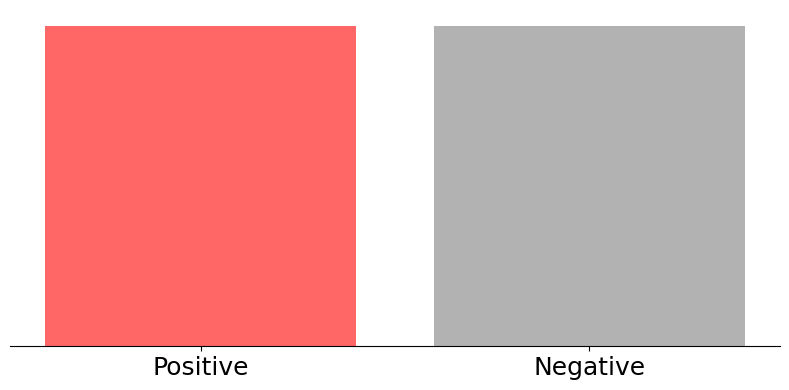

In [45]:
# Creating a DataFrame from the resampled data
feature_names = x_train.columns
df_resampled = pd.DataFrame(x_train_resampled, columns=feature_names)
df_resampled['Target'] = y_train_resampled
df_resampled['Target'].value_counts()

# Calculate counts and percentages
data = df_resampled['Target'].value_counts()
percentages = (data / data.sum()) * 100
result = pd.concat([data, percentages], axis=1).round(2)
label_map = {0: "Negative", 1: "Positive"}
result.index = result.index.map(label_map)
result.columns = ['Count', 'Percentage']

# Plotting
plt.figure(figsize=(8, 4))  # Define figure size
colors = ['red', 'grey']  # Color red for 'Positive', grey for 'Negative'
result_sorted = result.sort_index(ascending=False)  # Sort data for better visual hierarchy

# Create the bar plot vertically
bars = plt.bar(result_sorted.index, result_sorted['Count'], color=colors, alpha=0.6)

# Add text annotations inside the bars
for bar, (index, row) in zip(bars, result_sorted.iterrows()):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{row['Percentage']}%", color='white', va='bottom', ha='center', fontweight='bold', fontsize=10)

# Formatting details
plt.title('', fontsize=20)  # Set the plot title
plt.gca().spines['top'].set_visible(False)  # Hide the top spine
plt.gca().spines['right'].set_visible(False)  # Hide the right spine
plt.gca().spines['left'].set_visible(False)  # Optionally, hide the left spine

# Remove y-axis labels
plt.gca().yaxis.set_major_locator(plt.NullLocator())  # No y-ticks
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())  # No y-tick labels

# Set x-tick label size
plt.gca().xaxis.set_tick_params(labelsize=18)  # Bigger font size for x-ticks

plt.tight_layout()  # Adjust layout to fit the figure area
plt.show()

## Define the models

### Without SMOTE

In [46]:
# Initialize models with a range of hyperparameters
model_params = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {'C': [0.1, 1.0, 10.0]}
    },
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(),
        'params': {'max_depth': [3, 5, 7]}
    # },
    # 'RandomForestClassifier': {
    #     'model': RandomForestClassifier(),
    #     'params': {'n_estimators': [50, 100, 200]}
    },
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': [3]}
    },
    'XGBClassifier': {
        'model': XGBClassifier(),
        'params': {'n_estimators': [50, 100, 200]}
    # },
    # 'SVC': {
    #     'model': SVC(),
    #     'params': {'C': [0.1], 'kernel': ['linear', 'rbf']}
    }
}

## Modeling 2

In [70]:
#Split between X and Y ('pros_cancer')
x = df_encoded.drop(columns=['pros_cancer'])
y = df_encoded['pros_cancer']

## Logistic Regression

In [83]:
# Feature Scaling for input features.
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x) #Better the Min-Max

# Convert scaled features back to DataFrame
x_scaled = pd.DataFrame(x_scaled, columns=x.columns)

# Create a classifier object.
lr = linear_model.LogisticRegression(max_iter=1000)

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
metrics_list = []

# SMOTE object
smote = SMOTE(random_state=1)

# Perform stratified K-fold cross-validation
for train_index, test_index in skf.split(x_scaled, y):
    x_train_fold, x_test_fold = x_scaled.iloc[train_index], x_scaled.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    lr.fit(x_train_fold, y_train_fold)
    y_pred_fold = lr.predict(x_test_fold)
    y_proba_fold = lr.predict_proba(x_test_fold)[:, 1]
    
    # Calculate metrics
    acc = accuracy_score(y_test_fold, y_pred_fold)
    auc = roc_auc_score(y_test_fold, y_proba_fold)
    sens = recall_score(y_test_fold, y_pred_fold)  # Sensitivity is recall
    spec = recall_score(y_test_fold, y_pred_fold, pos_label=0)  # Specificity: consider positive label as 0
    f1 = f1_score(y_test_fold, y_pred_fold)
    
    metrics_list.append({
        'Accuracy': acc,
        'AUC': auc,
        'Sensitivity': sens,
        'Specificity': spec,
        'F1 Score': f1
    })
    

# Convert list of dicts to DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Calculate and print summary statistics
print('Metrics Summary:')
print(metrics_df.mean()*100)  # Multiply by 100 for percentage
print('\nStandard Deviations:')
print(metrics_df.std())

Metrics Summary:
Accuracy       88.851227
AUC            80.389420
Sensitivity     7.512458
Specificity    98.883018
F1 Score       12.869850
dtype: float64

Standard Deviations:
Accuracy       0.002534
AUC            0.015433
Sensitivity    0.013474
Specificity    0.002355
F1 Score       0.021759
dtype: float64


## Logistic Regression + SMOTE

In [129]:
# Feature Scaling for input features.
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x) #Better the Min-Max

# Convert scaled features back to DataFrame
x_scaled = pd.DataFrame(x_scaled, columns=x.columns)

# Create a classifier object.
lr = linear_model.LogisticRegression(max_iter=1000)

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
metrics_list = []

# SMOTE object
smote = SMOTE(random_state=1)

# Perform stratified K-fold cross-validation
for train_index, test_index in skf.split(x_scaled, y):
    x_train_fold, x_test_fold = x_scaled.iloc[train_index], x_scaled.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Apply SMOTE
    x_train_smote, y_train_smote = smote.fit_resample(x_train_fold, y_train_fold)
    
    lr.fit(x_train_smote, y_train_smote)
    y_pred_fold = lr.predict(x_test_fold)
    y_proba_fold = lr.predict_proba(x_test_fold)[:, 1]
    
    # Calculate metrics
    acc = accuracy_score(y_test_fold, y_pred_fold)
    auc = roc_auc_score(y_test_fold, y_proba_fold)
    sens = recall_score(y_test_fold, y_pred_fold)  # Sensitivity is recall
    spec = recall_score(y_test_fold, y_pred_fold, pos_label=0)  # Specificity: consider positive label as 0
    f1 = f1_score(y_test_fold, y_pred_fold)
    
    metrics_list.append({
        'Accuracy': acc,
        'AUC': auc,
        'Sensitivity': sens,
        'Specificity': spec,
        'F1 Score': f1
    })
    

# Convert list of dicts to DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Calculate and print summary statistics
print('Metrics Summary:')
print(metrics_df.mean()*100)  # Multiply by 100 for percentage
print('\nStandard Deviations:')
print(metrics_df.std())

Metrics Summary:
Accuracy       76.756078
AUC            80.517412
Sensitivity    68.780256
Specificity    77.739425
F1 Score       39.383570
dtype: float64

Standard Deviations:
Accuracy       0.007569
AUC            0.013707
Sensitivity    0.031094
Specificity    0.008630
F1 Score       0.014327
dtype: float64


In [153]:
# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dim_reducer', 'passthrough'),
    ('classifier', LogisticRegression(max_iter=1000))
     ])

# Define the hyperparameters grid to tune
param_grid = {
    'scaler': [StandardScaler()],
    'scaler__with_mean': [True, False],
    'scaler__with_std': [True, False],
    'dim_reducer': [PCA(), KernelPCA()], #Thats correct
    'dim_reducer__n_components': [0.90, 0.95, None],  # None means no dimensionality reduction applied
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l2', 'none'],
    'classifier__solver': ['lbfgs', 'sag'],
    'classifier__class_weight': [None, 'balanced'],
}

# Setup the GridSearchCV object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=StratifiedKFold(n_splits=2),
                           scoring='roc_auc', verbose=3, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(x, y)

# Best model after hyperparameter tuning
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score found: ", grid_search.best_score_)

Fitting 2 folds for each of 576 candidates, totalling 1152 fits


C:\Users\Lenovo\.conda\envs\learning\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
576 fits failed out of a total of 1152.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
192 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lenovo\.conda\envs\learning\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\.conda\envs\learning\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Lenovo\.conda\envs\learning\Lib\site-packages\sklearn\pipeline

Best parameters found:  {'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'sag', 'dim_reducer': PCA(), 'dim_reducer__n_components': None, 'scaler': StandardScaler(), 'scaler__with_mean': False, 'scaler__with_std': False}
Best ROC AUC score found:  0.8055942726796297


## Logistic Regression + SMOTE + PCA

In [117]:
# Feature Scaling for input features.
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x) #Better the Min-Max

# Convert scaled features back to DataFrame
x_scaled = pd.DataFrame(x_scaled, columns=x.columns)

# Create a classifier object.
lr = linear_model.LogisticRegression(max_iter=1000)

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
metrics_list = []

# Applying PCA
pca = PCA(n_components=0.96)  # Adjust the number of components as needed

# SMOTE object
smote = SMOTE(random_state=1)

# Perform stratified K-fold cross-validation
for train_index, test_index in skf.split(x_scaled, y):
    x_train_fold, x_test_fold = x_scaled.iloc[train_index], x_scaled.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Apply SMOTE
    x_train_smote, y_train_smote = smote.fit_resample(x_train_fold, y_train_fold)
    
    # Applying PCA
    x_train_pca = pca.fit_transform(x_train_smote)  # Fit PCA on the scaled data
    x_test_pca = pca.transform(x_test_fold)
        
    lr.fit(x_train_pca, y_train_smote)
    y_pred_fold = lr.predict(x_test_pca)
    y_proba_fold = lr.predict_proba(x_test_pca)[:, 1]
    
    # Calculate metrics
    acc = accuracy_score(y_test_fold, y_pred_fold)
    auc = roc_auc_score(y_test_fold, y_proba_fold)
    sens = recall_score(y_test_fold, y_pred_fold)  # Sensitivity is recall
    spec = recall_score(y_test_fold, y_pred_fold, pos_label=0)  # Specificity: consider positive label as 0
    f1 = f1_score(y_test_fold, y_pred_fold)
    
    metrics_list.append({
        'Accuracy': acc,
        'AUC': auc,
        'Sensitivity': sens,
        'Specificity': spec,
        'F1 Score': f1
    })
    

# Convert list of dicts to DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Calculate and print summary statistics
print('Metrics Summary:')
print(metrics_df.mean()*100)  # Multiply by 100 for percentage
print('\nStandard Deviations:')
print(metrics_df.std())

Metrics Summary:
Accuracy       76.682554
AUC            80.437333
Sensitivity    68.663638
Specificity    77.671204
F1 Score       39.260404
dtype: float64

Standard Deviations:
Accuracy       0.006442
AUC            0.013575
Sensitivity    0.033537
Specificity    0.008113
F1 Score       0.013592
dtype: float64


## XGBoost

In [98]:
# Feature Scaling for input features.
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled, columns=x.columns)  # Convert scaled features back to DataFrame

# Create a XGBoost classifier object
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=1)

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
metrics_list = []


# Perform stratified K-fold cross-validation
for train_index, test_index in skf.split(x_scaled, y):
    x_train_fold, x_test_fold = x_scaled.iloc[train_index], x_scaled.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    xgb_model.fit(x_train_fold, y_train_fold)
    y_pred_fold = xgb_model.predict(x_test_fold)
    y_proba_fold = xgb_model.predict_proba(x_test_fold)[:, 1]  # Get probabilities for AUC
    
    # Calculate metrics
    acc = accuracy_score(y_test_fold, y_pred_fold)
    auc = roc_auc_score(y_test_fold, y_proba_fold)
    sens = recall_score(y_test_fold, y_pred_fold)  # Sensitivity is recall
    spec = recall_score(y_test_fold, y_pred_fold, pos_label=0)  # Specificity: consider positive label as 0
    f1 = f1_score(y_test_fold, y_pred_fold)
    
    metrics_list.append({
        'Accuracy': acc,
        'AUC': auc,
        'Sensitivity': sens,
        'Specificity': spec,
        'F1 Score': f1
    })

# Convert list of dicts to DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Calculate and print summary statistics
print('Metrics Summary:')
print(metrics_df.mean()*100)  # Multiply by 100 for percentage
print('\nStandard Deviations:')
print(metrics_df.std())

Metrics Summary:
Accuracy       88.758500
AUC            79.481250
Sensitivity    12.230829
Specificity    98.197017
F1 Score       19.266156
dtype: float64

Standard Deviations:
Accuracy       0.002694
AUC            0.010458
Sensitivity    0.013744
Specificity    0.002787
F1 Score       0.019352
dtype: float64


## XGBoost + SMOTE

In [79]:
# Feature Scaling for input features.
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled, columns=x.columns)  # Convert scaled features back to DataFrame

# Create a XGBoost classifier object
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=1)

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
metrics_list = []

# SMOTE object
smote = SMOTE(random_state=1)

# Perform stratified K-fold cross-validation
for train_index, test_index in skf.split(x_scaled, y):
    x_train_fold, x_test_fold = x_scaled.iloc[train_index], x_scaled.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Apply SMOTE
    x_train_smote, y_train_smote = smote.fit_resample(x_train_fold, y_train_fold)
    
    xgb_model.fit(x_train_smote, y_train_smote)
    y_pred_fold = xgb_model.predict(x_test_fold)
    y_proba_fold = xgb_model.predict_proba(x_test_fold)[:, 1]  # Get probabilities for AUC
    
    # Calculate metrics
    acc = accuracy_score(y_test_fold, y_pred_fold)
    auc = roc_auc_score(y_test_fold, y_proba_fold)
    sens = recall_score(y_test_fold, y_pred_fold)  # Sensitivity is recall
    spec = recall_score(y_test_fold, y_pred_fold, pos_label=0)  # Specificity: consider positive label as 0
    f1 = f1_score(y_test_fold, y_pred_fold)
    
    metrics_list.append({
        'Accuracy': acc,
        'AUC': auc,
        'Sensitivity': sens,
        'Specificity': spec,
        'F1 Score': f1
    })

# Convert list of dicts to DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Calculate and print summary statistics
print('Metrics Summary:')
print(metrics_df.mean()*100)  # Multiply by 100 for percentage
print('\nStandard Deviations:')
print(metrics_df.std())

Metrics Summary:
Accuracy       87.789750
AUC            79.035773
Sensitivity    19.480897
Specificity    96.214491
F1 Score       25.933304
dtype: float64

Standard Deviations:
Accuracy       0.004813
AUC            0.008930
Sensitivity    0.015825
Specificity    0.005885
F1 Score       0.017366
dtype: float64


## XGBoost + SMOTE + PCA

In [121]:
# Feature Scaling for input features.
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled, columns=x.columns)  # Convert scaled features back to DataFrame

# Create a XGBoost classifier object
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=1)

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
metrics_list = []

# SMOTE object
smote = SMOTE(random_state=1)

# Perform stratified K-fold cross-validation
for train_index, test_index in skf.split(x_scaled, y):
    x_train_fold, x_test_fold = x_scaled.iloc[train_index], x_scaled.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Apply SMOTE
    x_train_smote, y_train_smote = smote.fit_resample(x_train_fold, y_train_fold)
    
    # Applying PCA
    x_train_pca = pca.fit_transform(x_train_smote)  # Fit PCA on the scaled data
    x_test_pca = pca.transform(x_test_fold)

    xgb_model.fit(x_train_pca, y_train_smote)
    y_pred_fold = xgb_model.predict(x_test_pca)
    y_proba_fold = xgb_model.predict_proba(x_test_pca)[:, 1]  # Get probabilities for AUC
    
    # Calculate metrics
    acc = accuracy_score(y_test_fold, y_pred_fold)
    auc = roc_auc_score(y_test_fold, y_proba_fold)
    sens = recall_score(y_test_fold, y_pred_fold)  # Sensitivity is recall
    spec = recall_score(y_test_fold, y_pred_fold, pos_label=0)  # Specificity: consider positive label as 0
    f1 = f1_score(y_test_fold, y_pred_fold)
    
    metrics_list.append({
        'Accuracy': acc,
        'AUC': auc,
        'Sensitivity': sens,
        'Specificity': spec,
        'F1 Score': f1
    })

# Convert list of dicts to DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Calculate and print summary statistics
print('Metrics Summary:')
print(metrics_df.mean()*100)  # Multiply by 100 for percentage
print('\nStandard Deviations:')
print(metrics_df.std())

Metrics Summary:
Accuracy       74.179045
AUC            63.410380
Sensitivity    42.022510
Specificity    78.145279
F1 Score       26.322420
dtype: float64

Standard Deviations:
Accuracy       0.009398
AUC            0.017416
Sensitivity    0.030623
Specificity    0.011010
F1 Score       0.016441
dtype: float64


## Attempts Score History
 - 0.89 (Medical History and Tests) (Logit)
 - 0.92 with precision of 0.96 (Xgboost)